In [ ]:
#Импорт библиотек
!sudo apt install tesseract-ocr
!pip install pytesseract
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
import gc
import pytesseract
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, Embedding, Flatten, Conv2DTranspose, concatenate, UpSampling2D,Conv2D, MaxPooling1D
from google.colab.patches import cv2_imshow
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%load_ext tensorboard

In [ ]:
# Качаем набор данных
!gdown "https://drive.google.com/uc?id=1L28XBd1zg8ZMYK5nrwvAOq2oCcAXURhC" # Анализы с меткой(плохо через 1 алгоритм нахождения таблиц проходит)
!gdown "https://drive.google.com/uc?id=1re-1e9ktgIrdfKFKGYEaIVfusVo06hJH" # Анализы
!gdown "https://drive.google.com/uc?id=11ZiGA-YAvA0JD34O-Y-ujFh5RecVdCNH" # Мармот с хорошим определением таблицы

In [ ]:
# Разархивация данных
!unzip "/content/___________.zip" -d "/content/"
!unzip "/content/_______.zip" -d "/content/"
!unzip "/content/_______good.zip" -d "/content/"

In [ ]:
# Переименовываем папки с данными
os.rename("Расчерчены хорошо","Расчерчены")
os.rename("мармот хорошие только","Data")
os.rename("Расчерчены  с тегом таблицы","Расчерчены1")

In [ ]:
#Подсчитываем количество файлов документов и аннотаций
fc, annc = 0,0
fc1, annc1 = 0,0
fc2, annc2 = 0,0

for f in os.listdir("/content/Расчерчены/"):
  if f.endswith("xml") and os.path.isfile("/content/Расчерчены/"+ f[:-4] +".jpg"):
    annc += 1
  if f.endswith("jpg"):
    fc += 1

for f in os.listdir("/content/Расчерчены1/"):
  if f.endswith("xml") and os.path.isfile("/content/Расчерчены1/"+ f[:-4] +".jpg"):
    annc1 += 1
  if f.endswith("jpg"):
    fc1 += 1

for f in os.listdir("/content/Data/"):
  if f.endswith("xml") and os.path.isfile("/content/Data/"+ f[:-4] +".bmp"):
    annc2 += 1
  if f.endswith("bmp"):
    fc2 += 1


print("Количество анализов (jpg) :", fc + fc1)
print("Количество аннотаций анализов (xml) :", annc + annc1)
print()
print("Общее количество файлов документов (bmp) :", fc2)
print("Количество документов с аннотациями (xml) :", annc2)

Количество анализов (jpg) : 110
Количество аннотаций анализов (xml) : 110

Общее количество файлов документов (bmp) : 396
Количество документов с аннотациями (xml) : 396


In [ ]:
#Вычисляет евклидово расстояние между 2 точками
def euc_dist(point1, point2):
  dist = np.linalg.norm(point1 - point2)
  return dist

#Сохраняет изображение на диск
def save_image(name, image_arr):
  im = Image.fromarray(image_arr)
  im.save(name)

In [ ]:
def generate_mask(path_file, path_xml, storage_path_table, storage_path_col, filenames) :
  '''Создает маски столбцов и таблиц из аннотаций, которые хорошо работает без аномалий(1 алгоритм)'''

  # чтение xml-файла
  tree = ET.parse(path_xml+path_file+".xml")
  root = tree.getroot()


  size = root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)
  depth = int(size.find('depth').text)

  # создание пустой маски изображения
  col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
  table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

  table_xmin = 0
  table_ymin = 0
  table_xmax = 0
  table_ymax = 0
  prev_dist = 0
  dist = 0
  forward_flag = False
  backward_flag = False
  newtable_flag = True
  col_cnt = 0

  # извлечение данных из аннотации
  objects = tree.findall('object')

# Определение маски столбцов и таблицы 
  for index, object in enumerate(objects):
    bndbox = object.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)
        
    col_mask_empty[ymin:ymax, xmin:xmax] = 255
        
    col_cnt += 1  
        
    if index == 0:
      prev_xmin = int(bndbox.find('xmin').text)
      prev_ymin = int(bndbox.find('ymin').text)
      prev_xmax = int(bndbox.find('xmax').text)
      prev_ymax = int(bndbox.find('ymax').text)
            
                
    else:  
      if xmin > prev_xmin and newtable_flag:
        table_xmin = prev_xmin
        table_ymin = prev_ymin
        newtable_flag = False
        forward_flag = True
        backward_flag = False

      if xmin < prev_xmin and newtable_flag:

        table_xmax = prev_xmax
        table_ymax = prev_ymax
                
                
        newtable_flag = False
        backward_flag = True
        forward_flag = False



      if forward_flag:
        dist = euc_dist(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))

        if prev_dist == 0:
          prev_dist = dist
        else:
          if int(np.divide(dist, prev_dist)) > 5:
            newtable_flag = True
            table_mask_empty[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255

            prev_dist = 0
            col_cnt = 0
                        
          if index==len(objects)-1:
            newtable_flag = True
            table_mask_empty[table_ymin:ymax, table_xmin:xmax] = 255
            

            prev_dist = 0
            col_cnt = 0

      if backward_flag:
        dist = euc_dist(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))

        if prev_dist == 0:
          prev_dist = dist
        else:
          if int(np.divide(dist, prev_dist)) > 5 or index==len(objects)-1:
            newtable_flag = True
            table_mask_empty[ymin:table_ymax, xmin:table_xmax] = 255

            prev_dist = 0
            col_cnt = 0            
                
    prev_xmin = int(bndbox.find('xmin').text)
    prev_ymin = int(bndbox.find('ymin').text)
    prev_xmax = int(bndbox.find('xmax').text)
    prev_ymax = int(bndbox.find('ymax').text)
    prev_dist = dist

  #Добавляем путь к изображению, на которое были созданы маски 
  filenames.append(path_file)

  #Сохраняем маски 
  save_image(storage_path_table+"/" + path_file+"_tbl.jpeg", table_mask_empty)
  save_image(storage_path_col+"/" + path_file+"_col.jpeg", col_mask_empty)

In [ ]:
#Класс, который нужен для определения масок таблицы изображения (являются аномалиями для первого алгоритма )
class tabel_class:
  def __init__(self):
    self.list_table_x = []
    self.list_table_y = []

  def add_column(self, xmin : int, xmax : int, ymin : int, ymax : int):
    self.list_table_x.append(xmin)
    self.list_table_y.append(ymin)
    self.list_table_x.append(xmax)
    self.list_table_y.append(ymax)

  def get_xmin(self):
    return min(self.list_table_x)

  def get_ymin(self):
    return min(self.list_table_y)

  def get_xmax(self):
    return max(self.list_table_x)

  def get_ymax(self):
    return max(self.list_table_y)

In [ ]:
def generate_mask1(path_file, path_xml, storage_path_table, storage_path_col, filenames) :
  '''Создает маски столбцов и таблиц из аннотаций, которые хорошо работает с аномалиями(2 алгоритм)'''

  # чтение xml-файла
  tree = ET.parse(path_xml+path_file+".xml")
  root = tree.getroot()


  size = root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)
  depth = int(size.find('depth').text)

  # текущая расматриваямая таблица
  current_table = 1
  # словарь таблиц на фото 
  dict_table = {}


  # создание пустой маски изображения
  col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
  table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)


  # извлечение данных из аннотации
  objects = tree.findall('object')

  for index, object in enumerate(objects):
    table_num = int(object.find('table_num').text)
    bndbox = object.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)
        
    col_mask_empty[ymin:ymax, xmin:xmax] = 255

    if table_num not in dict_table:
      dict_table[table_num] = tabel_class()
      dict_table[table_num].add_column(xmin, xmax, ymin, ymax)
    else:
      dict_table[table_num].add_column(xmin, xmax, ymin, ymax)
    
  for key in dict_table:
    obj_table = dict_table[key]
    table_mask_empty[obj_table.get_ymin():obj_table.get_ymax(), obj_table.get_xmin():obj_table.get_xmax()] = 255

  #Добавляем путь к изображению, на которое были созданы маски 
  filenames.append(path_file)

  #Сохраняем маски 
  save_image(storage_path_table+"/" + path_file+"_tbl.jpeg", table_mask_empty)
  save_image(storage_path_col+"/" + path_file+"_col.jpeg", col_mask_empty)


In [ ]:
table_mask_path = "Table_Mask"
col_mask_path = "Column_Mask"

table_mask_path1 = "Table_Mask1"
col_mask_path1 = "Column_Mask1"

#table_mask_path2 = "Table_Mask2"
#col_mask_path2 = "Column_Mask2"

path = "/content/Расчерчены/"
path1 = "/content/Расчерчены1/"
#path2 = "/content/Data/"

#создаем папки если, они не существуют
if os.path.isdir(table_mask_path) == False:
  os.mkdir(table_mask_path)
if os.path.isdir(col_mask_path) == False:
  os.mkdir(col_mask_path)

if os.path.isdir(table_mask_path1) == False:
  os.mkdir(table_mask_path1)
if os.path.isdir(col_mask_path1) == False:
  os.mkdir(col_mask_path1)

#if os.path.isdir(table_mask_path2) == False:
  #os.mkdir(table_mask_path2)
#if os.path.isdir(col_mask_path2) == False:
  #os.mkdir(col_mask_path2)

filenames = []
filenames1 = []
#filenames2 = []

#Создаём маски для наших изображений разных папок
for filename in os.listdir(path):
  if filename.endswith("xml") and os.path.isfile(path + filename[:-4] +".jpg"):
    generate_mask(filename[:-4],path, table_mask_path, col_mask_path, filenames)

for filename in os.listdir(path1):
  if filename.endswith("xml") and os.path.isfile(path1+ filename[:-4] +".jpg"):
    generate_mask1(filename[:-4], path1, table_mask_path1, col_mask_path1, filenames1)

#for filename in os.listdir(path2):
  #if filename.endswith("xml") and os.path.isfile(path2+ filename[:-4] +".bmp"):
    #generate_mask(filename[:-4], path2, table_mask_path2, col_mask_path2, filenames2)

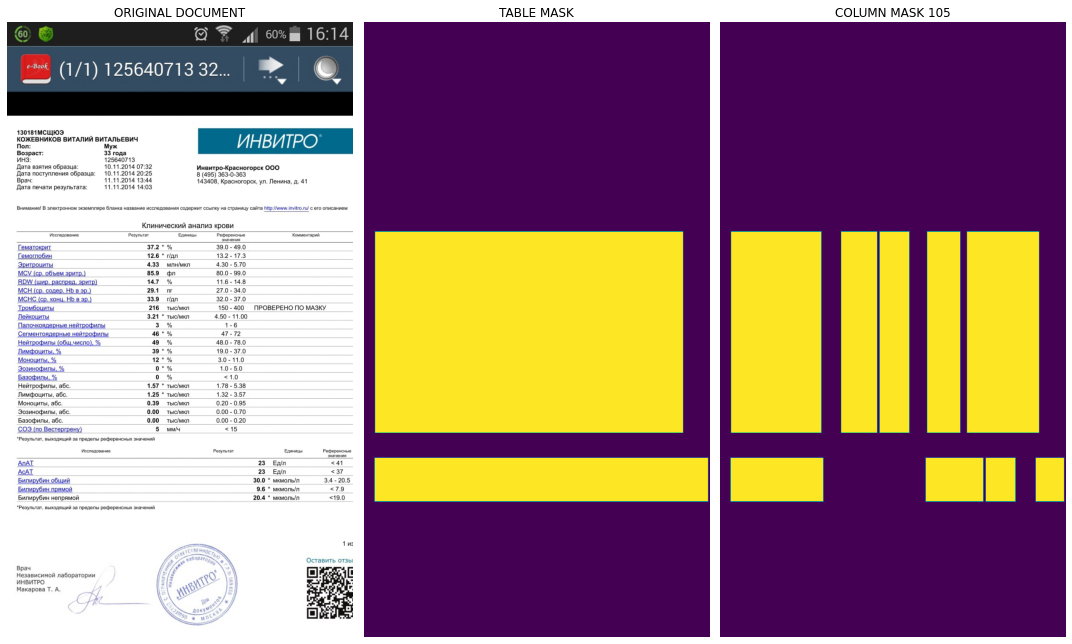

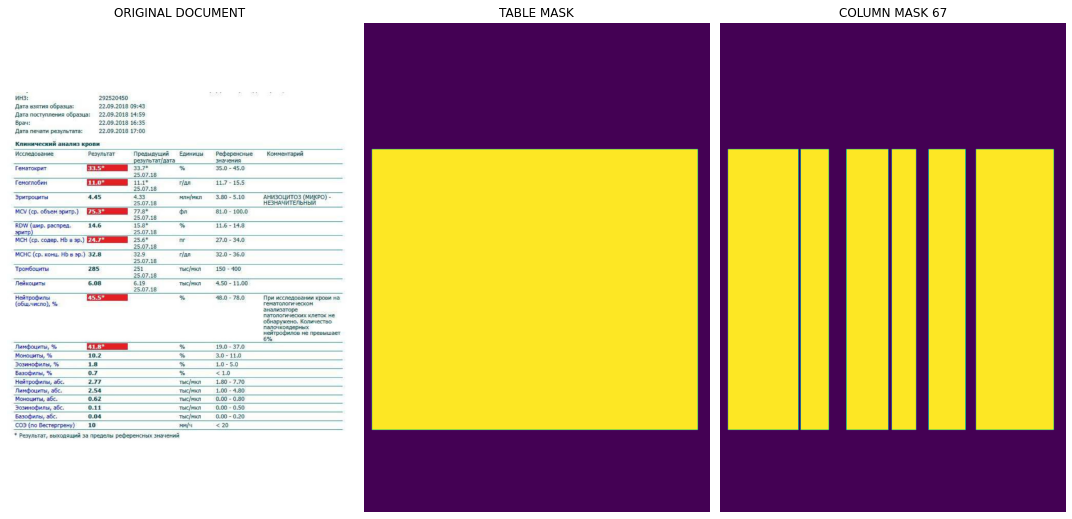

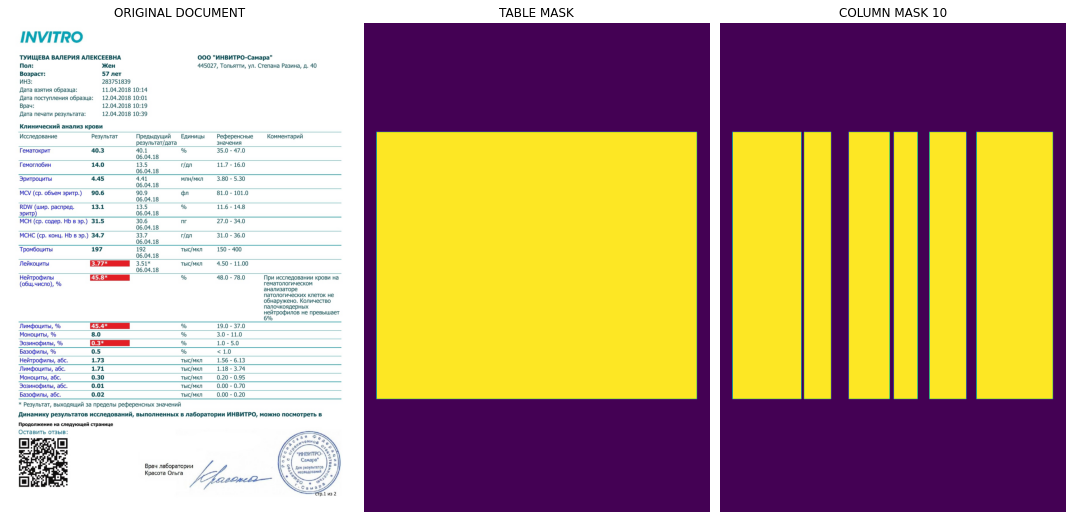

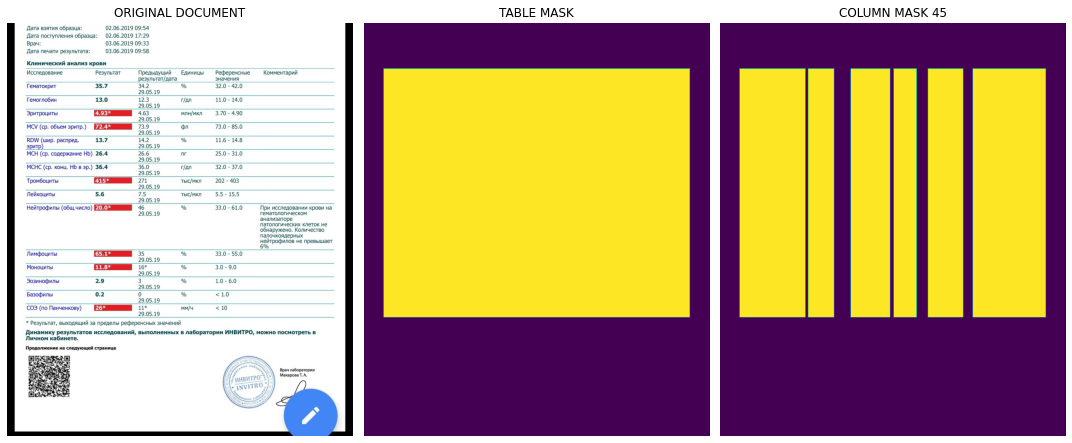

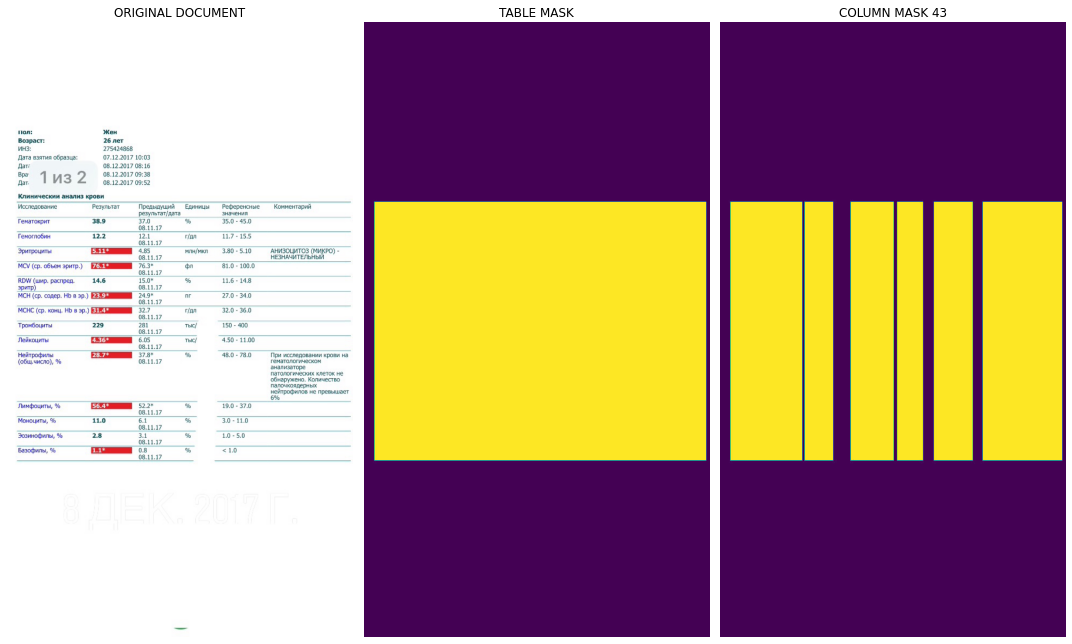

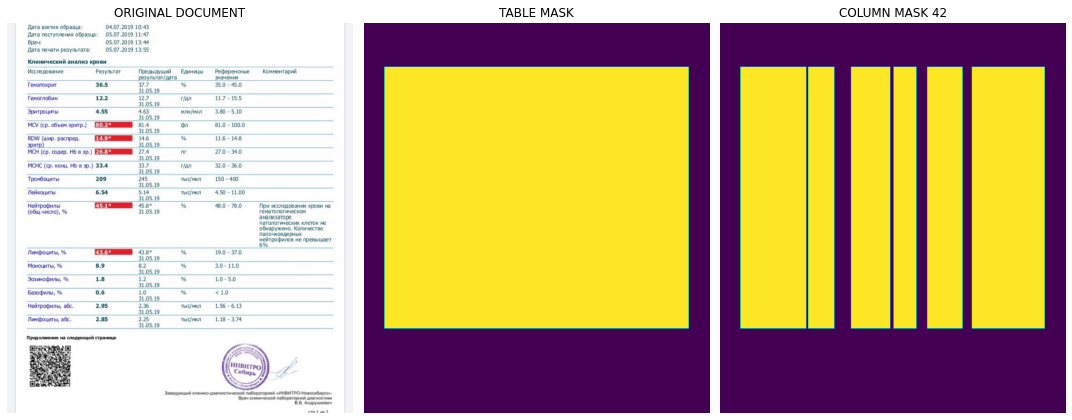

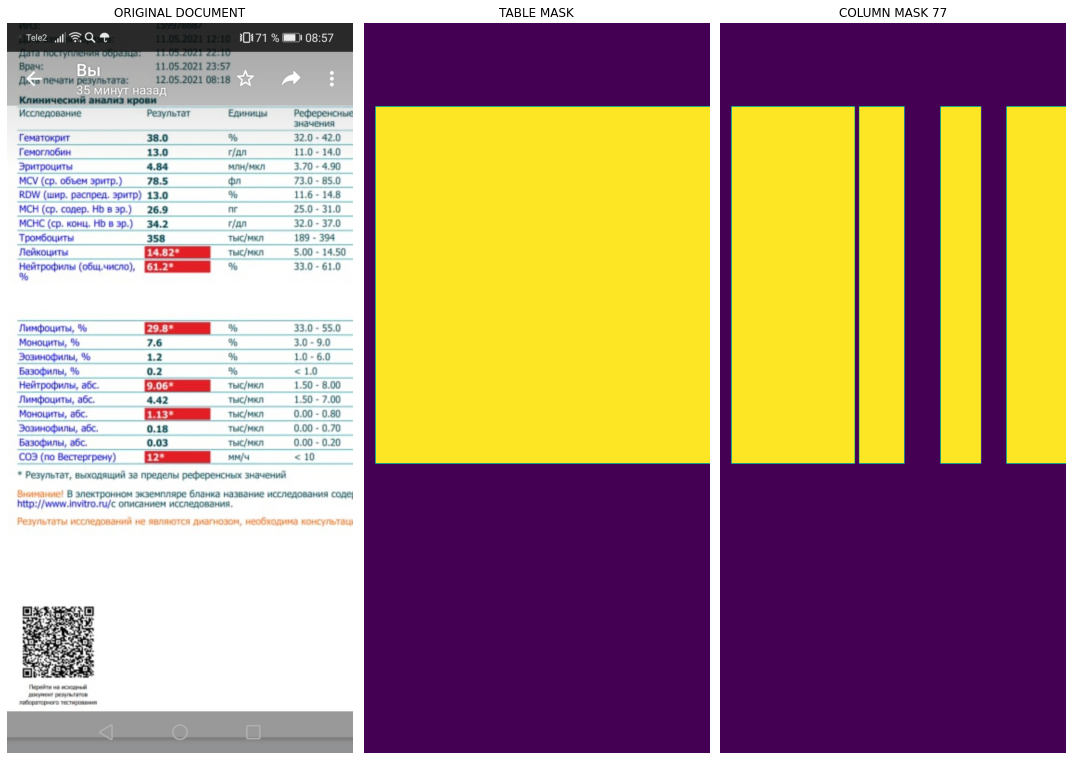

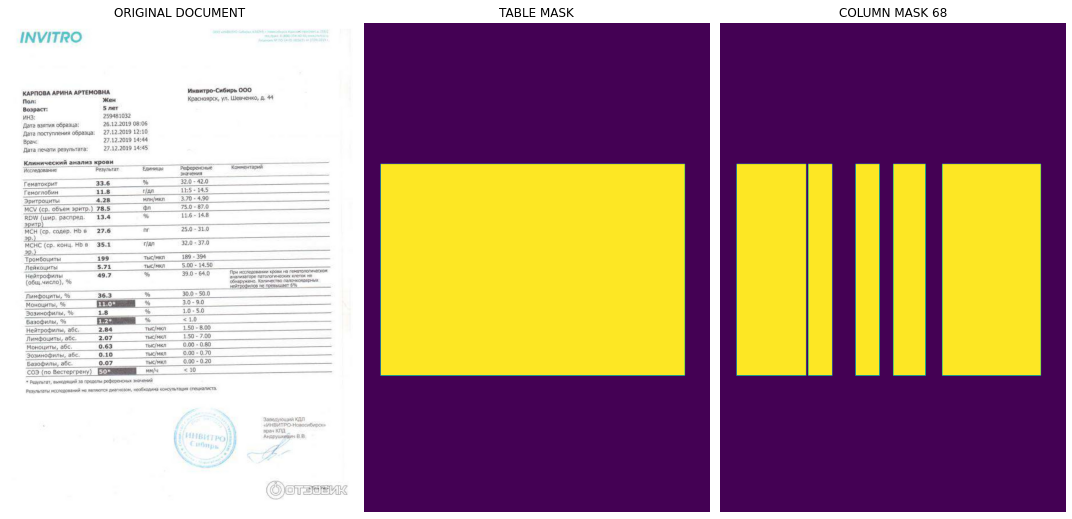

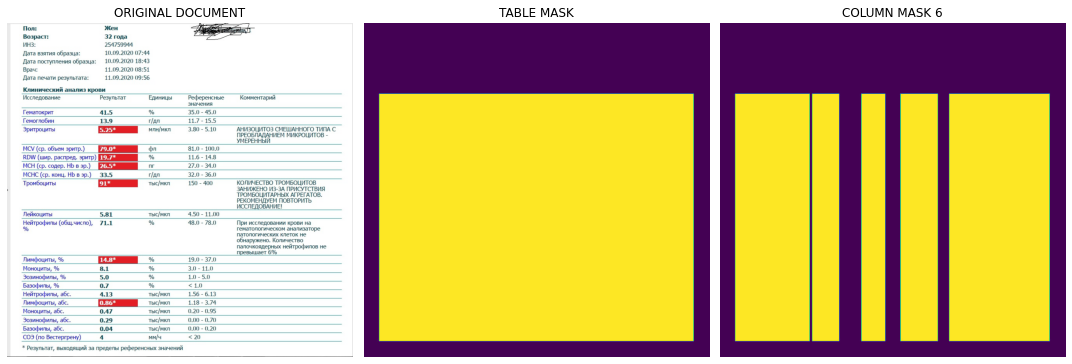

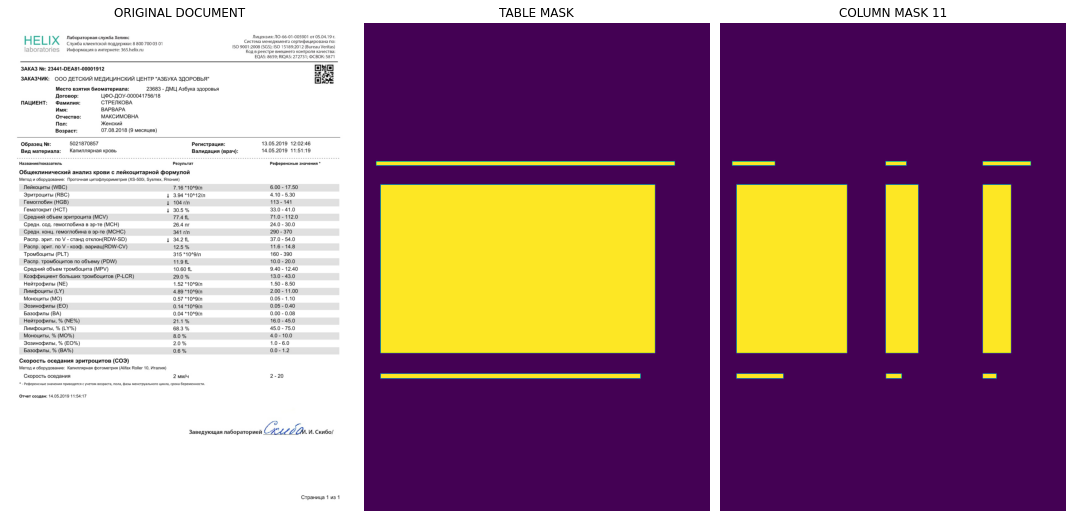

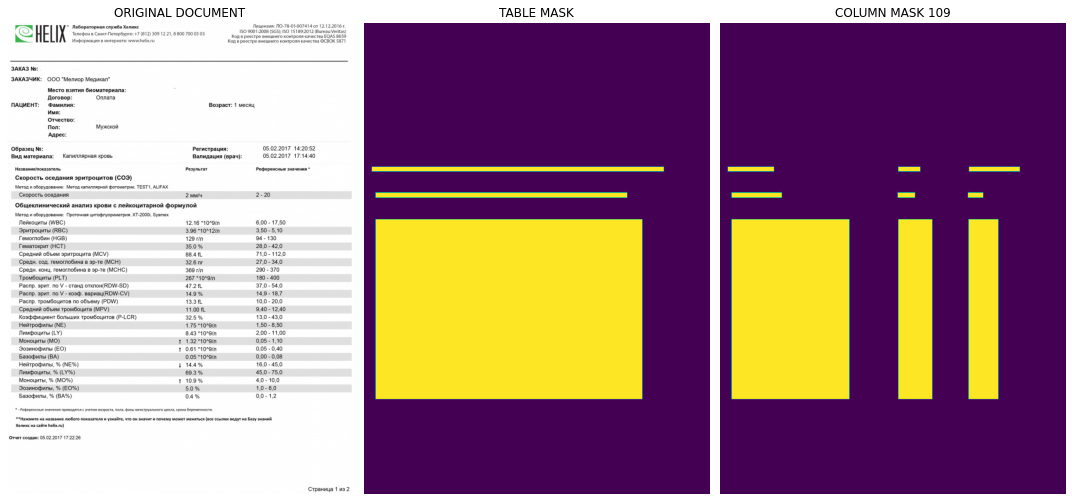

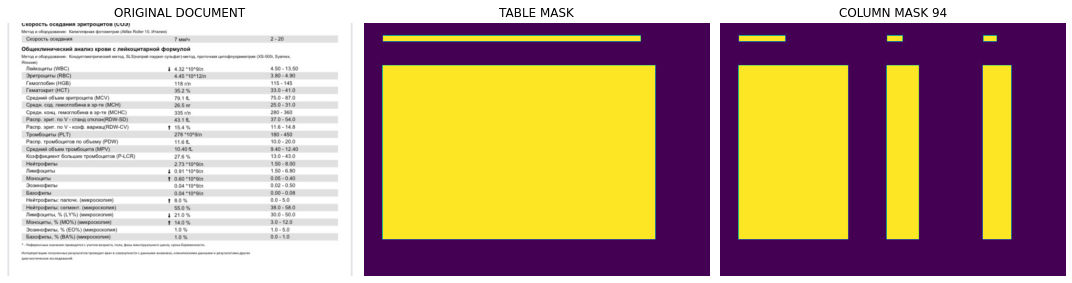

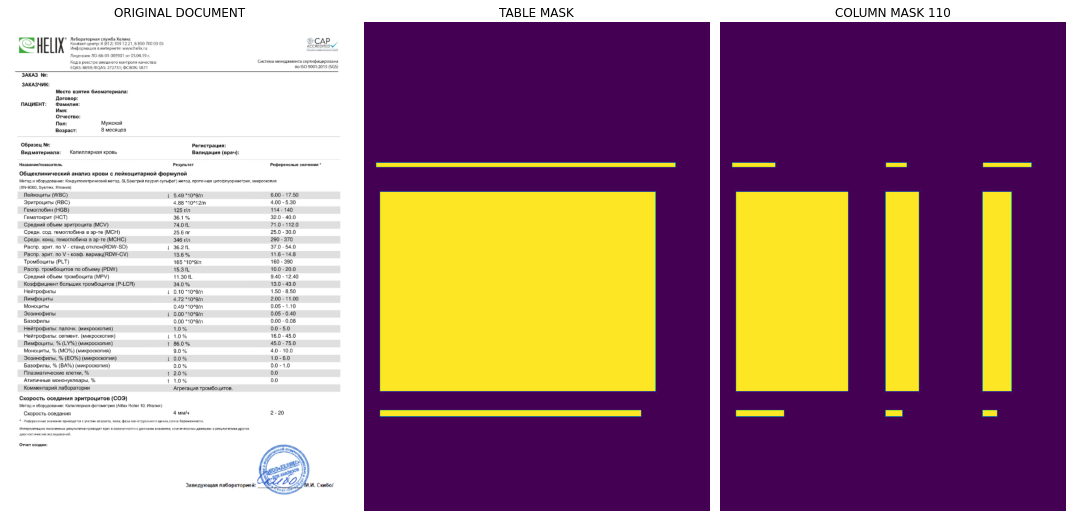

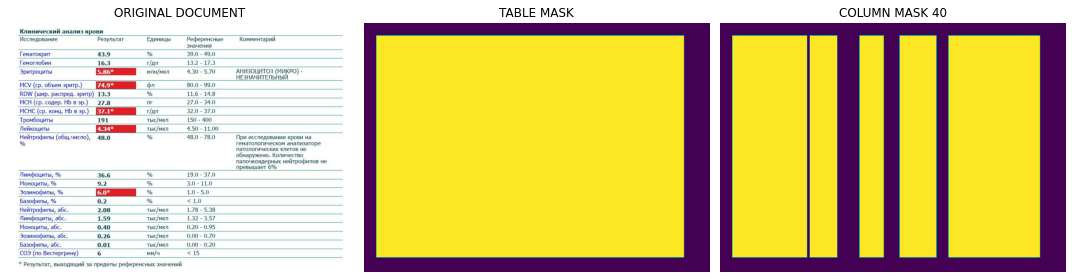

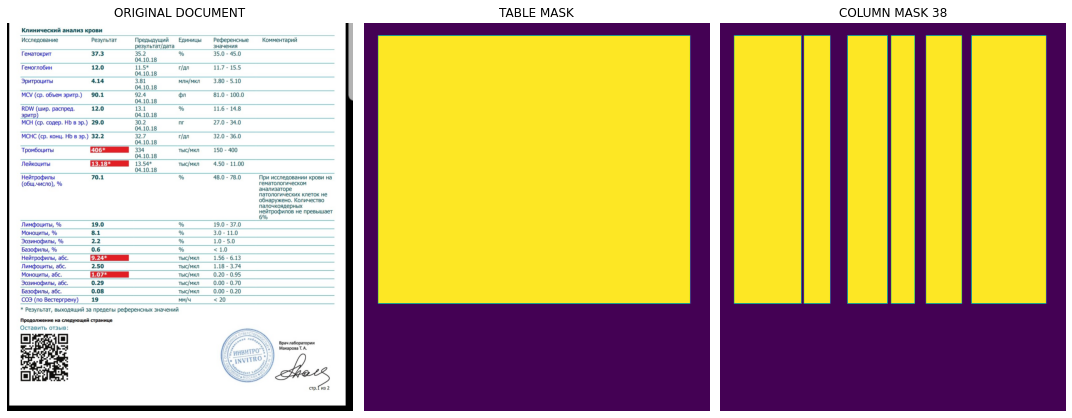

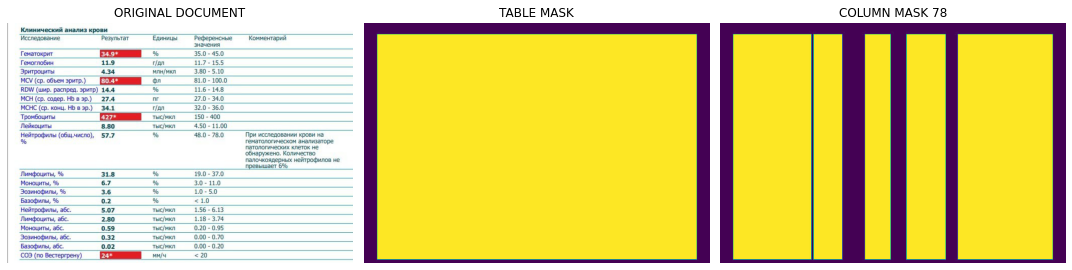

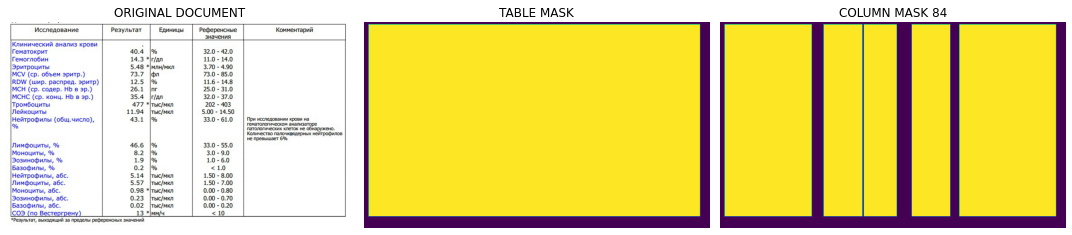

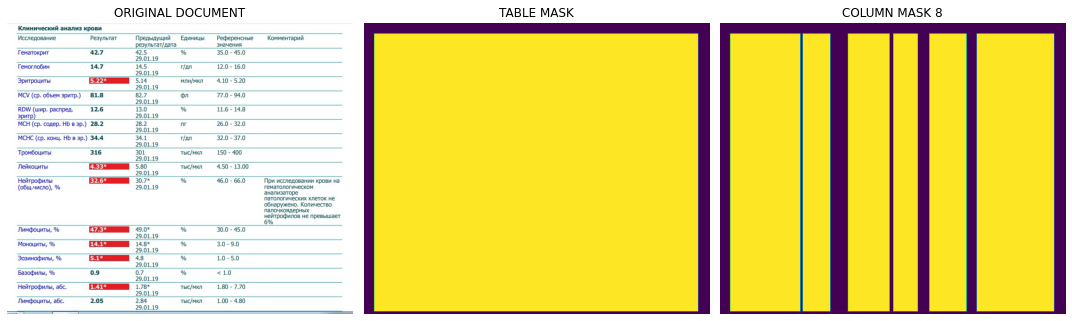

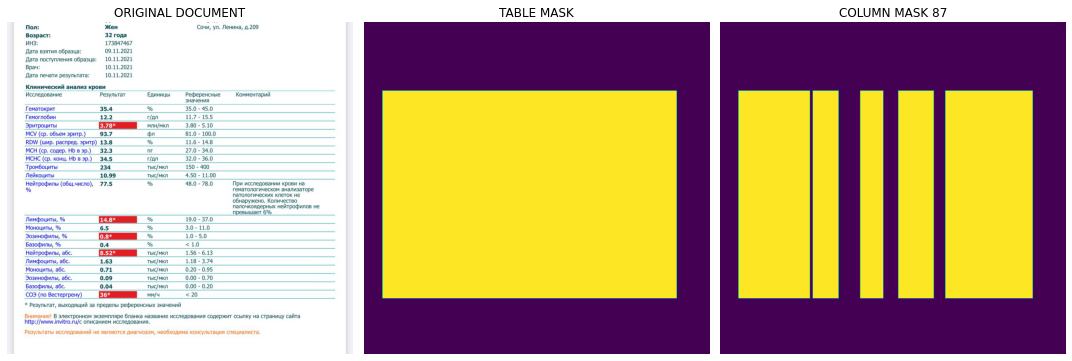

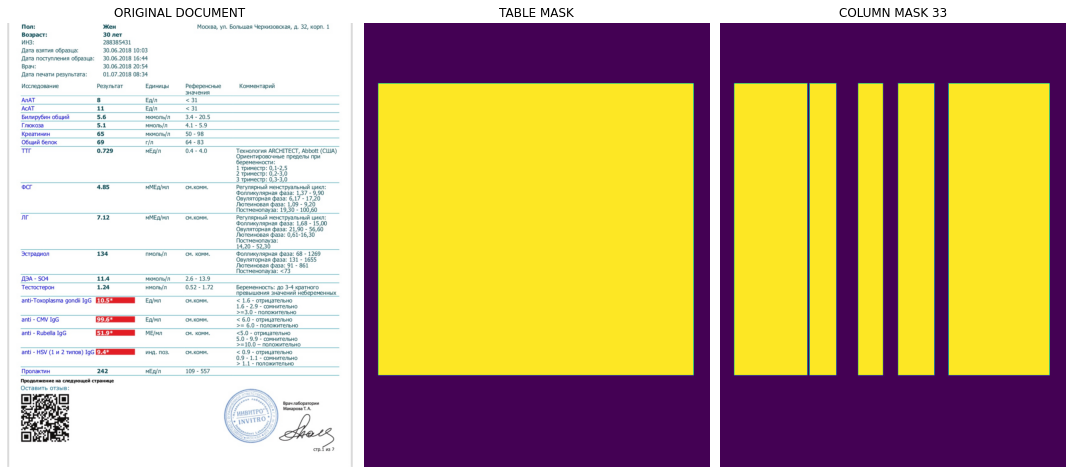

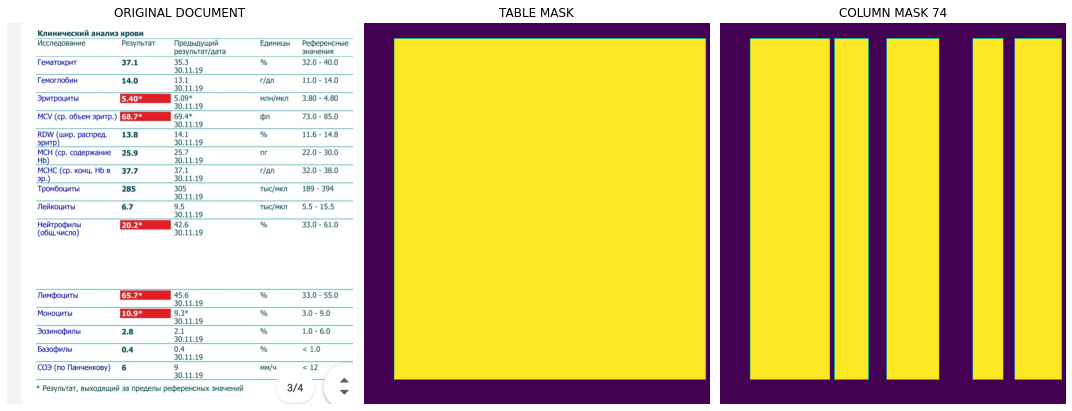

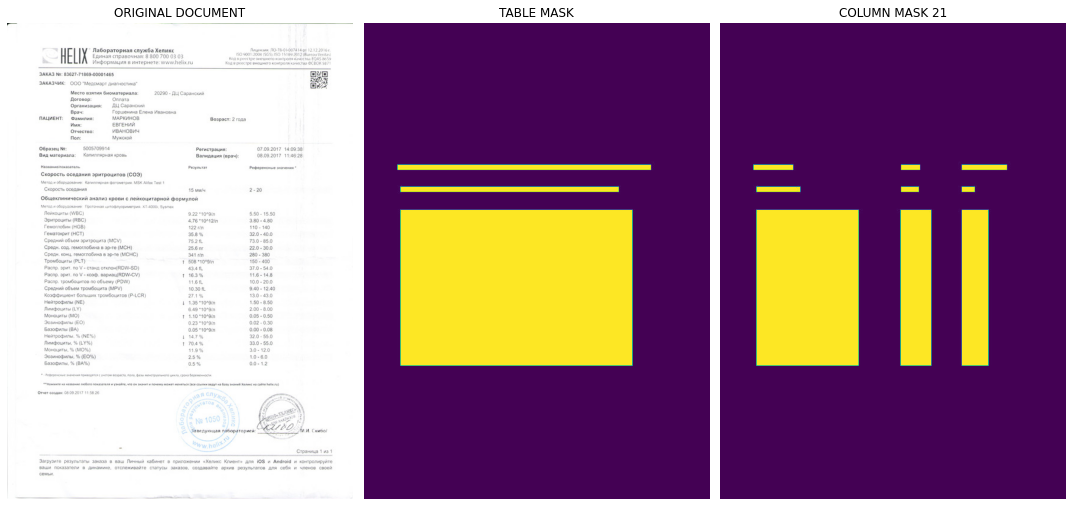

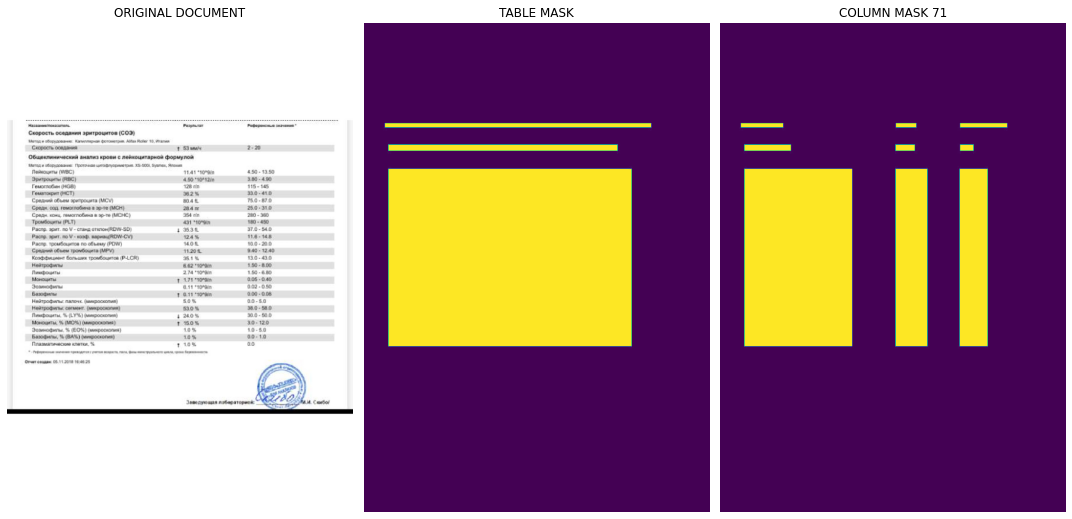

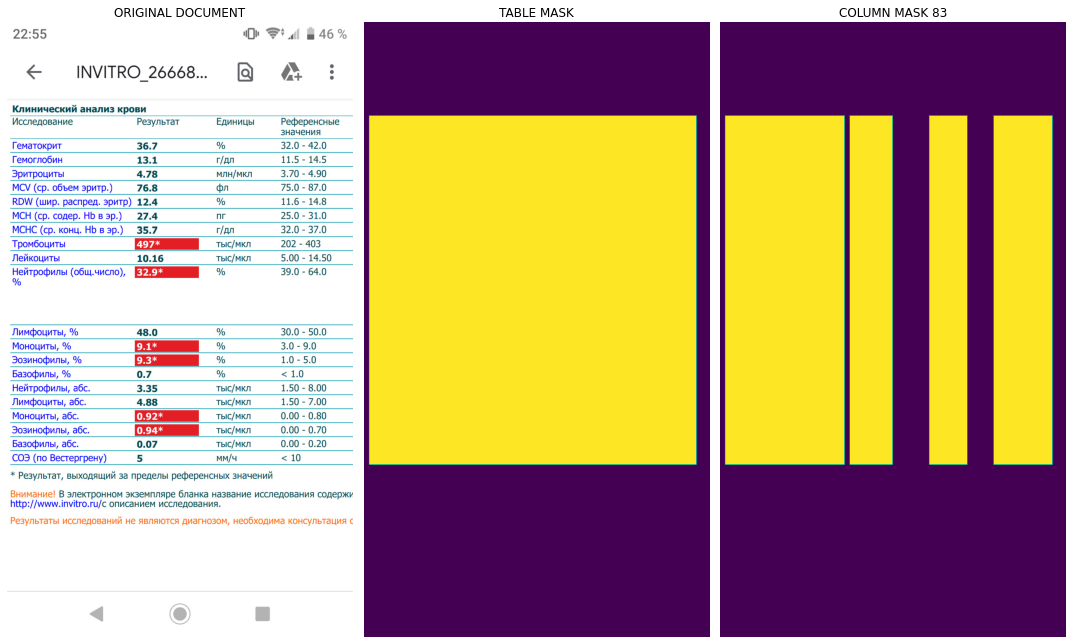

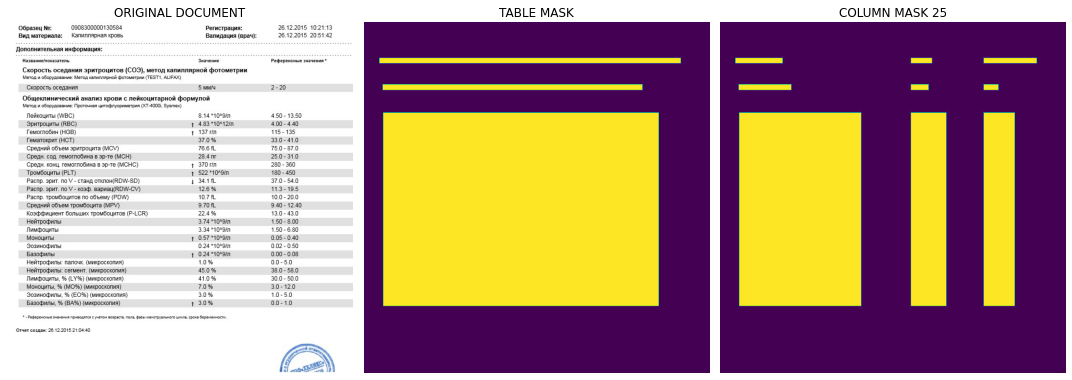

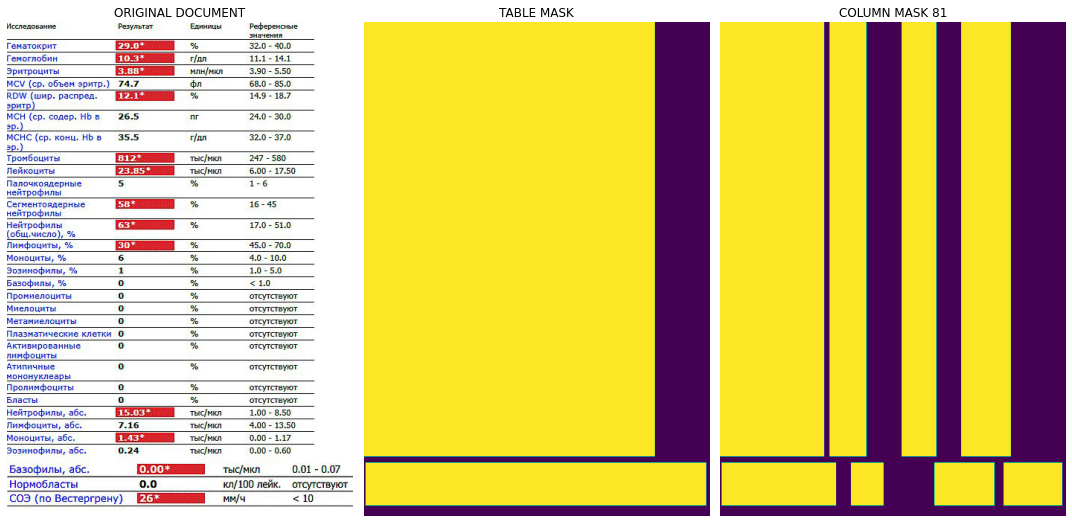

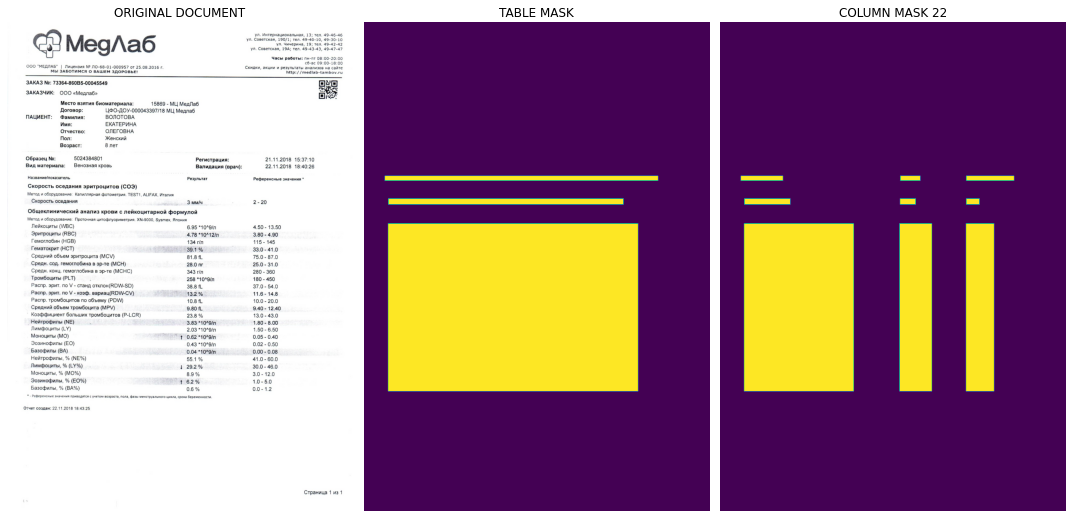

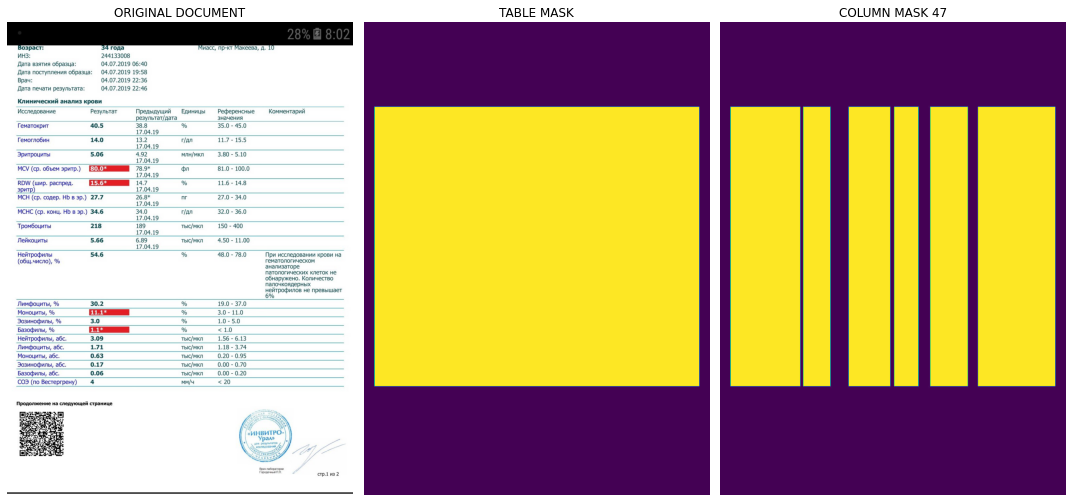

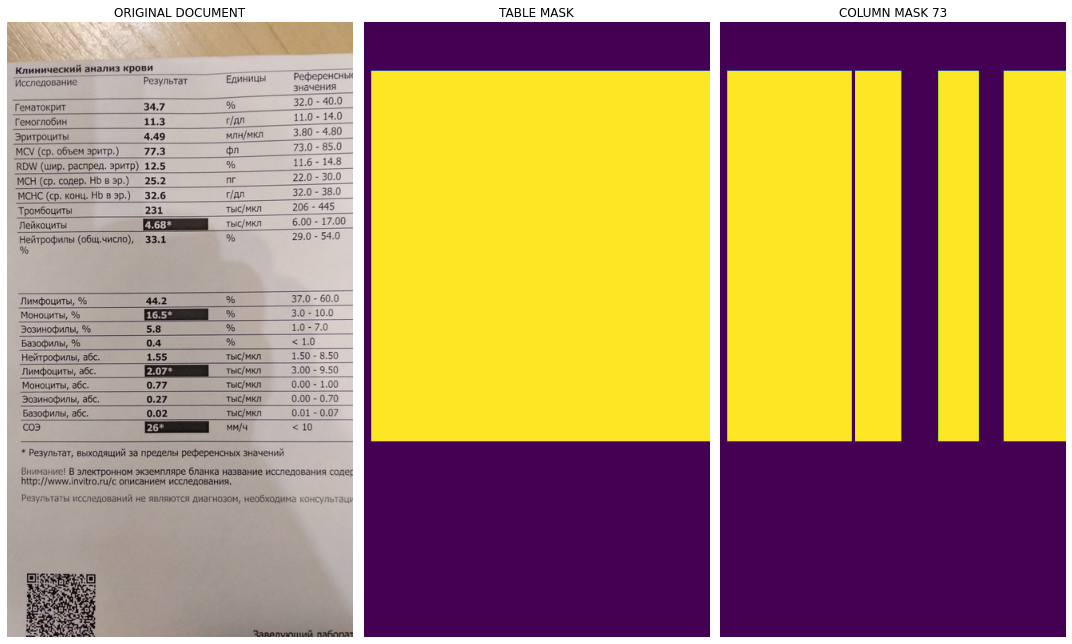

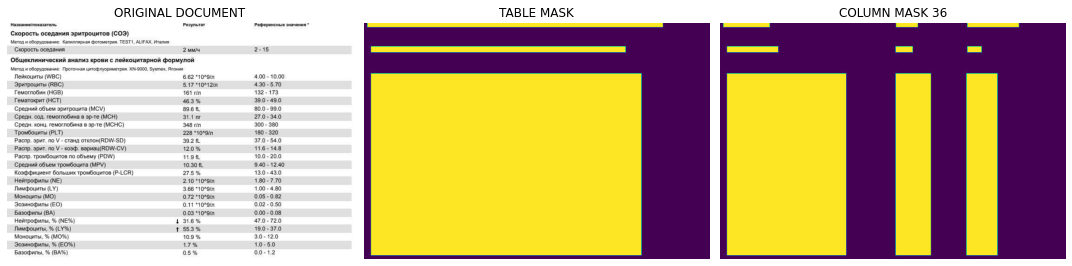

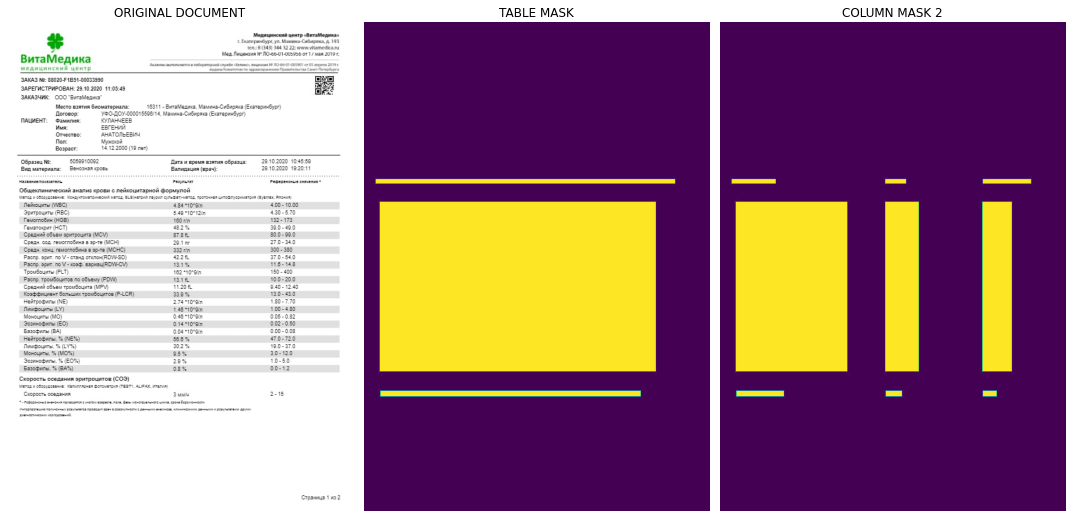

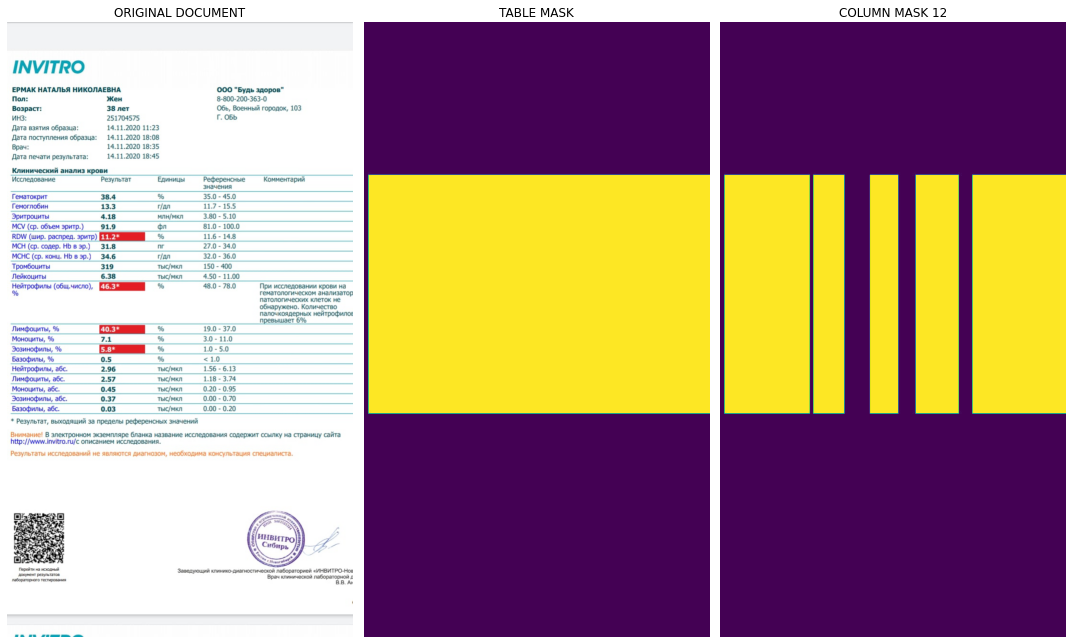

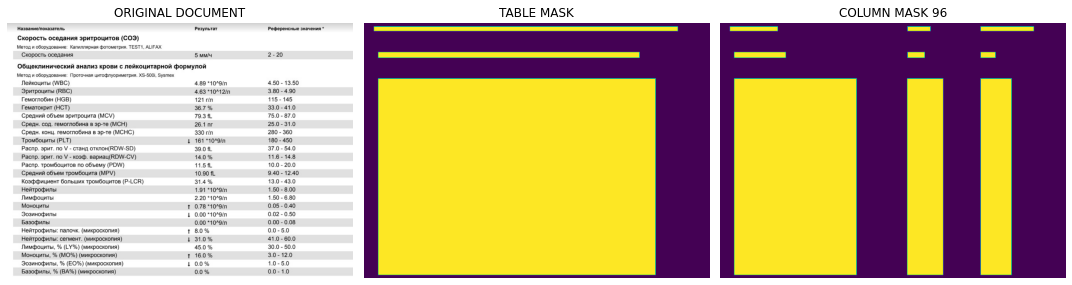

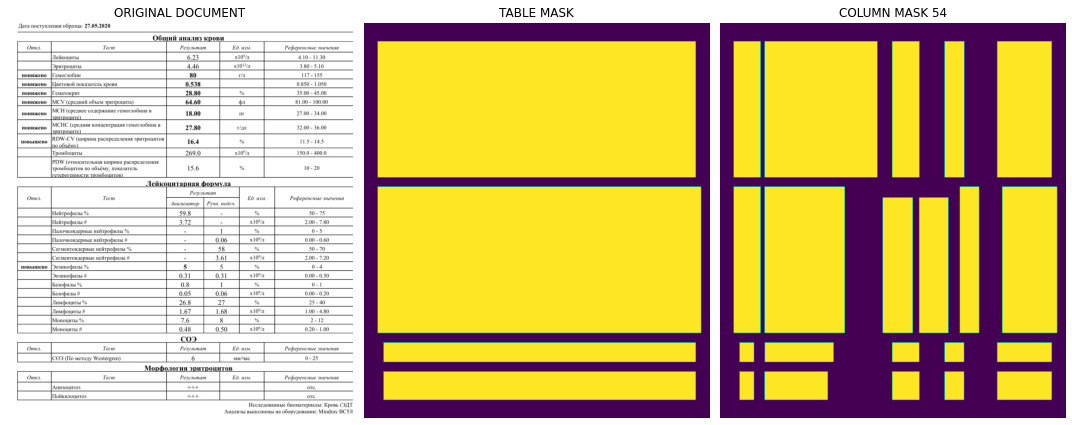

In [ ]:
for f in os.listdir("/content/Расчерчены1/"):
  if f.endswith("jpg"):
    fig = plt.figure(figsize=(15, 20))

    img = Image.open(f"/content/Расчерчены1/{f[:-4]}.jpg")
    fig.add_subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("ORIGINAL DOCUMENT")

    img = Image.open(f"/content/Table_Mask1/{f[:-4]}_tbl.jpeg")
    fig.add_subplot(1, 3, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.title("TABLE MASK")

    img = Image.open(f"/content/Column_Mask1/{f[:-4]}_col.jpeg")
    fig.add_subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"COLUMN MASK {f[:-4]}")


    fig.tight_layout()

In [ ]:
#создаём дата фрейм, где будут хранится данные о пути изображения и его маски
images   = []
tbl_mask = []
col_mask = []
df = pd.DataFrame()

for fname in filenames :
  images.append(str("/content/Расчерчены/"+fname+".jpg"))
  tbl_mask.append(str("/content/Table_Mask/"+fname+"_tbl.jpeg"))
  col_mask.append(str("/content/Column_Mask/"+fname+"_col.jpeg"))

for fname in filenames1 :
  images.append(str("/content/Расчерчены1/"+fname+".jpg"))
  tbl_mask.append(str("/content/Table_Mask1/"+fname+"_tbl.jpeg"))
  col_mask.append(str("/content/Column_Mask1/"+fname+"_col.jpeg"))

#for fname in filenames2 :
  #images.append(str("/content/Data/"+fname+".bmp"))
  #tbl_mask.append(str("/content/Table_Mask2/"+fname+"_tbl.jpeg"))
  #col_mask.append(str("/content/Column_Mask2/"+fname+"_col.jpeg"))

df["Image"] = images
df["Table_Mask"] = tbl_mask
df["Column_Mask"] = col_mask

df.head(5)

Image  ...                       Column_Mask
0  /content/Расчерчены/26.jpg  ...  /content/Column_Mask/26_col.jpeg
1  /content/Расчерчены/72.jpg  ...  /content/Column_Mask/72_col.jpeg
2  /content/Расчерчены/60.jpg  ...  /content/Column_Mask/60_col.jpeg
3  /content/Расчерчены/19.jpg  ...  /content/Column_Mask/19_col.jpeg
4  /content/Расчерчены/50.jpg  ...  /content/Column_Mask/50_col.jpeg

[5 rows x 3 columns]

In [ ]:
# возвращает два подмножества тестовой и обучающей выборки
Train, Test = train_test_split(df, test_size = 0.2)

Train_Data = tf.data.Dataset.from_tensor_slices(
    (
        Train["Image"].values,
        Train["Table_Mask"].values,
        Train["Column_Mask"].values
    )
)

Test_Data  =  tf.data.Dataset.from_tensor_slices(
    (
        Test["Image"].values,
        Test["Table_Mask"].values,
        Test["Column_Mask"].values
    )
)

In [ ]:
@tf.function
def load_images(doc, tbl_mask, col_mask):
  """Считывает файлы изображений и масок, декодирует и предварительно обрабатывает их"""

  doc = tf.io.read_file(doc)
  doc = tf.io.decode_image(doc, channels=3, expand_animations = False)
  doc = tf.image.resize(doc, [1024,1024])
  doc = tf.cast(doc, tf.float32) / 255.0

  tbl_mask = tf.io.read_file(tbl_mask)
  tbl_mask = tf.io.decode_jpeg(tbl_mask, channels=1)
  tbl_mask = tf.image.resize(tbl_mask, [1024,1024])
  tbl_mask = tf.cast(tbl_mask, tf.float32) / 255.0
  
  col_mask = tf.io.read_file(col_mask)
  col_mask = tf.io.decode_jpeg(col_mask, channels=1)
  col_mask = tf.image.resize(col_mask, [1024,1024])
  col_mask = tf.cast(col_mask, tf.float32) / 255.0
  
  return doc, {"Table_mask" : tbl_mask, "Column_mask" : col_mask}


def load_data(BATCH_SIZE, BUFFER_SIZE):
  """Загружает данные пакетами для обучения и тестирования"""

  train_steps = len(Train) // BATCH_SIZE
  val_steps = len(Test) // BATCH_SIZE

  train_dataset = Train_Dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #.prefetch(tf.data.AUTOTUNE)
  test_dataset  = Test_Dataset.batch(BATCH_SIZE)

  return train_dataset, test_dataset, train_steps, val_steps


Train_Dataset = Train_Data.map(load_images, num_parallel_calls= tf.data.AUTOTUNE)
Test_Dataset  = Test_Data.map(load_images, num_parallel_calls= tf.data.AUTOTUNE)

In [ ]:
class tbl_decoder(tf.keras.layers.Layer):
  def __init__(self, name = "Table_mask"):
    super().__init__(name = name)
    self.conv1 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.umsample1 = UpSampling2D(size = (2,2),)
    self.umsample2 = UpSampling2D(size = (2,2),)
    self.umsample3 = UpSampling2D(size = (2,2),)
    self.umsample4 = UpSampling2D(size = (2,2),)
    self.convtranspose = Conv2DTranspose( filters=3, kernel_size=3, strides=2, padding = 'same')

  def call(self, X):

    input,pool_3,pool_4 = X[0],X[1],X[2]
    x = self.conv1(input)
    x = self.umsample1(x)
    x = concatenate([x, pool_4])
    x = self.umsample2(x)
    x = concatenate([x, pool_3])
    x = self.umsample3(x)
    x = self.umsample4(x)
    x = self.convtranspose(x)

    return x

class col_decoder(tf.keras.layers.Layer):
  def __init__(self, name = "Column_mask"):
    super().__init__(name = name)
    self.conv1 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.drop  = Dropout(0.8)
    self.conv2 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.umsample1 = UpSampling2D(size = (2,2),)
    self.umsample2 = UpSampling2D(size = (2,2),)
    self.umsample3 = UpSampling2D(size = (2,2),)
    self.umsample4 = UpSampling2D(size = (2,2),)
    self.convtranspose = Conv2DTranspose( filters=3, kernel_size=3, strides=2, padding = 'same')

  def call(self, X):

    input,pool_3,pool_4 = X[0],X[1],X[2]
    x = self.conv1(input)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.umsample1(x)
    x = concatenate([x, pool_4])
    x = self.umsample2(x)
    x = concatenate([x, pool_3])
    x = self.umsample3(x)
    x = self.umsample4(x)
    x = self.convtranspose(x)

    return x

In [ ]:
#создаём модель
input = Input(shape=(1024,1024,3))
vgg19 = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_tensor=input, classes= 1000)

x = vgg19.output
pool_3 = vgg19.get_layer('block3_pool').output
pool_4 = vgg19.get_layer('block4_pool').output

x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(x)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)

Table_Decoder  = tbl_decoder()
Column_Decoder = col_decoder()

output1 = Table_Decoder([x, pool_3, pool_4])
output2 = Column_Decoder([x, pool_3, pool_4])

model = Model(inputs = input, outputs= [output1,output2], name = "TableNet")
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "TableNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, 1024, 1024,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, 1024, 1024,   36928       ['block1_conv1[0][0]']           
                          

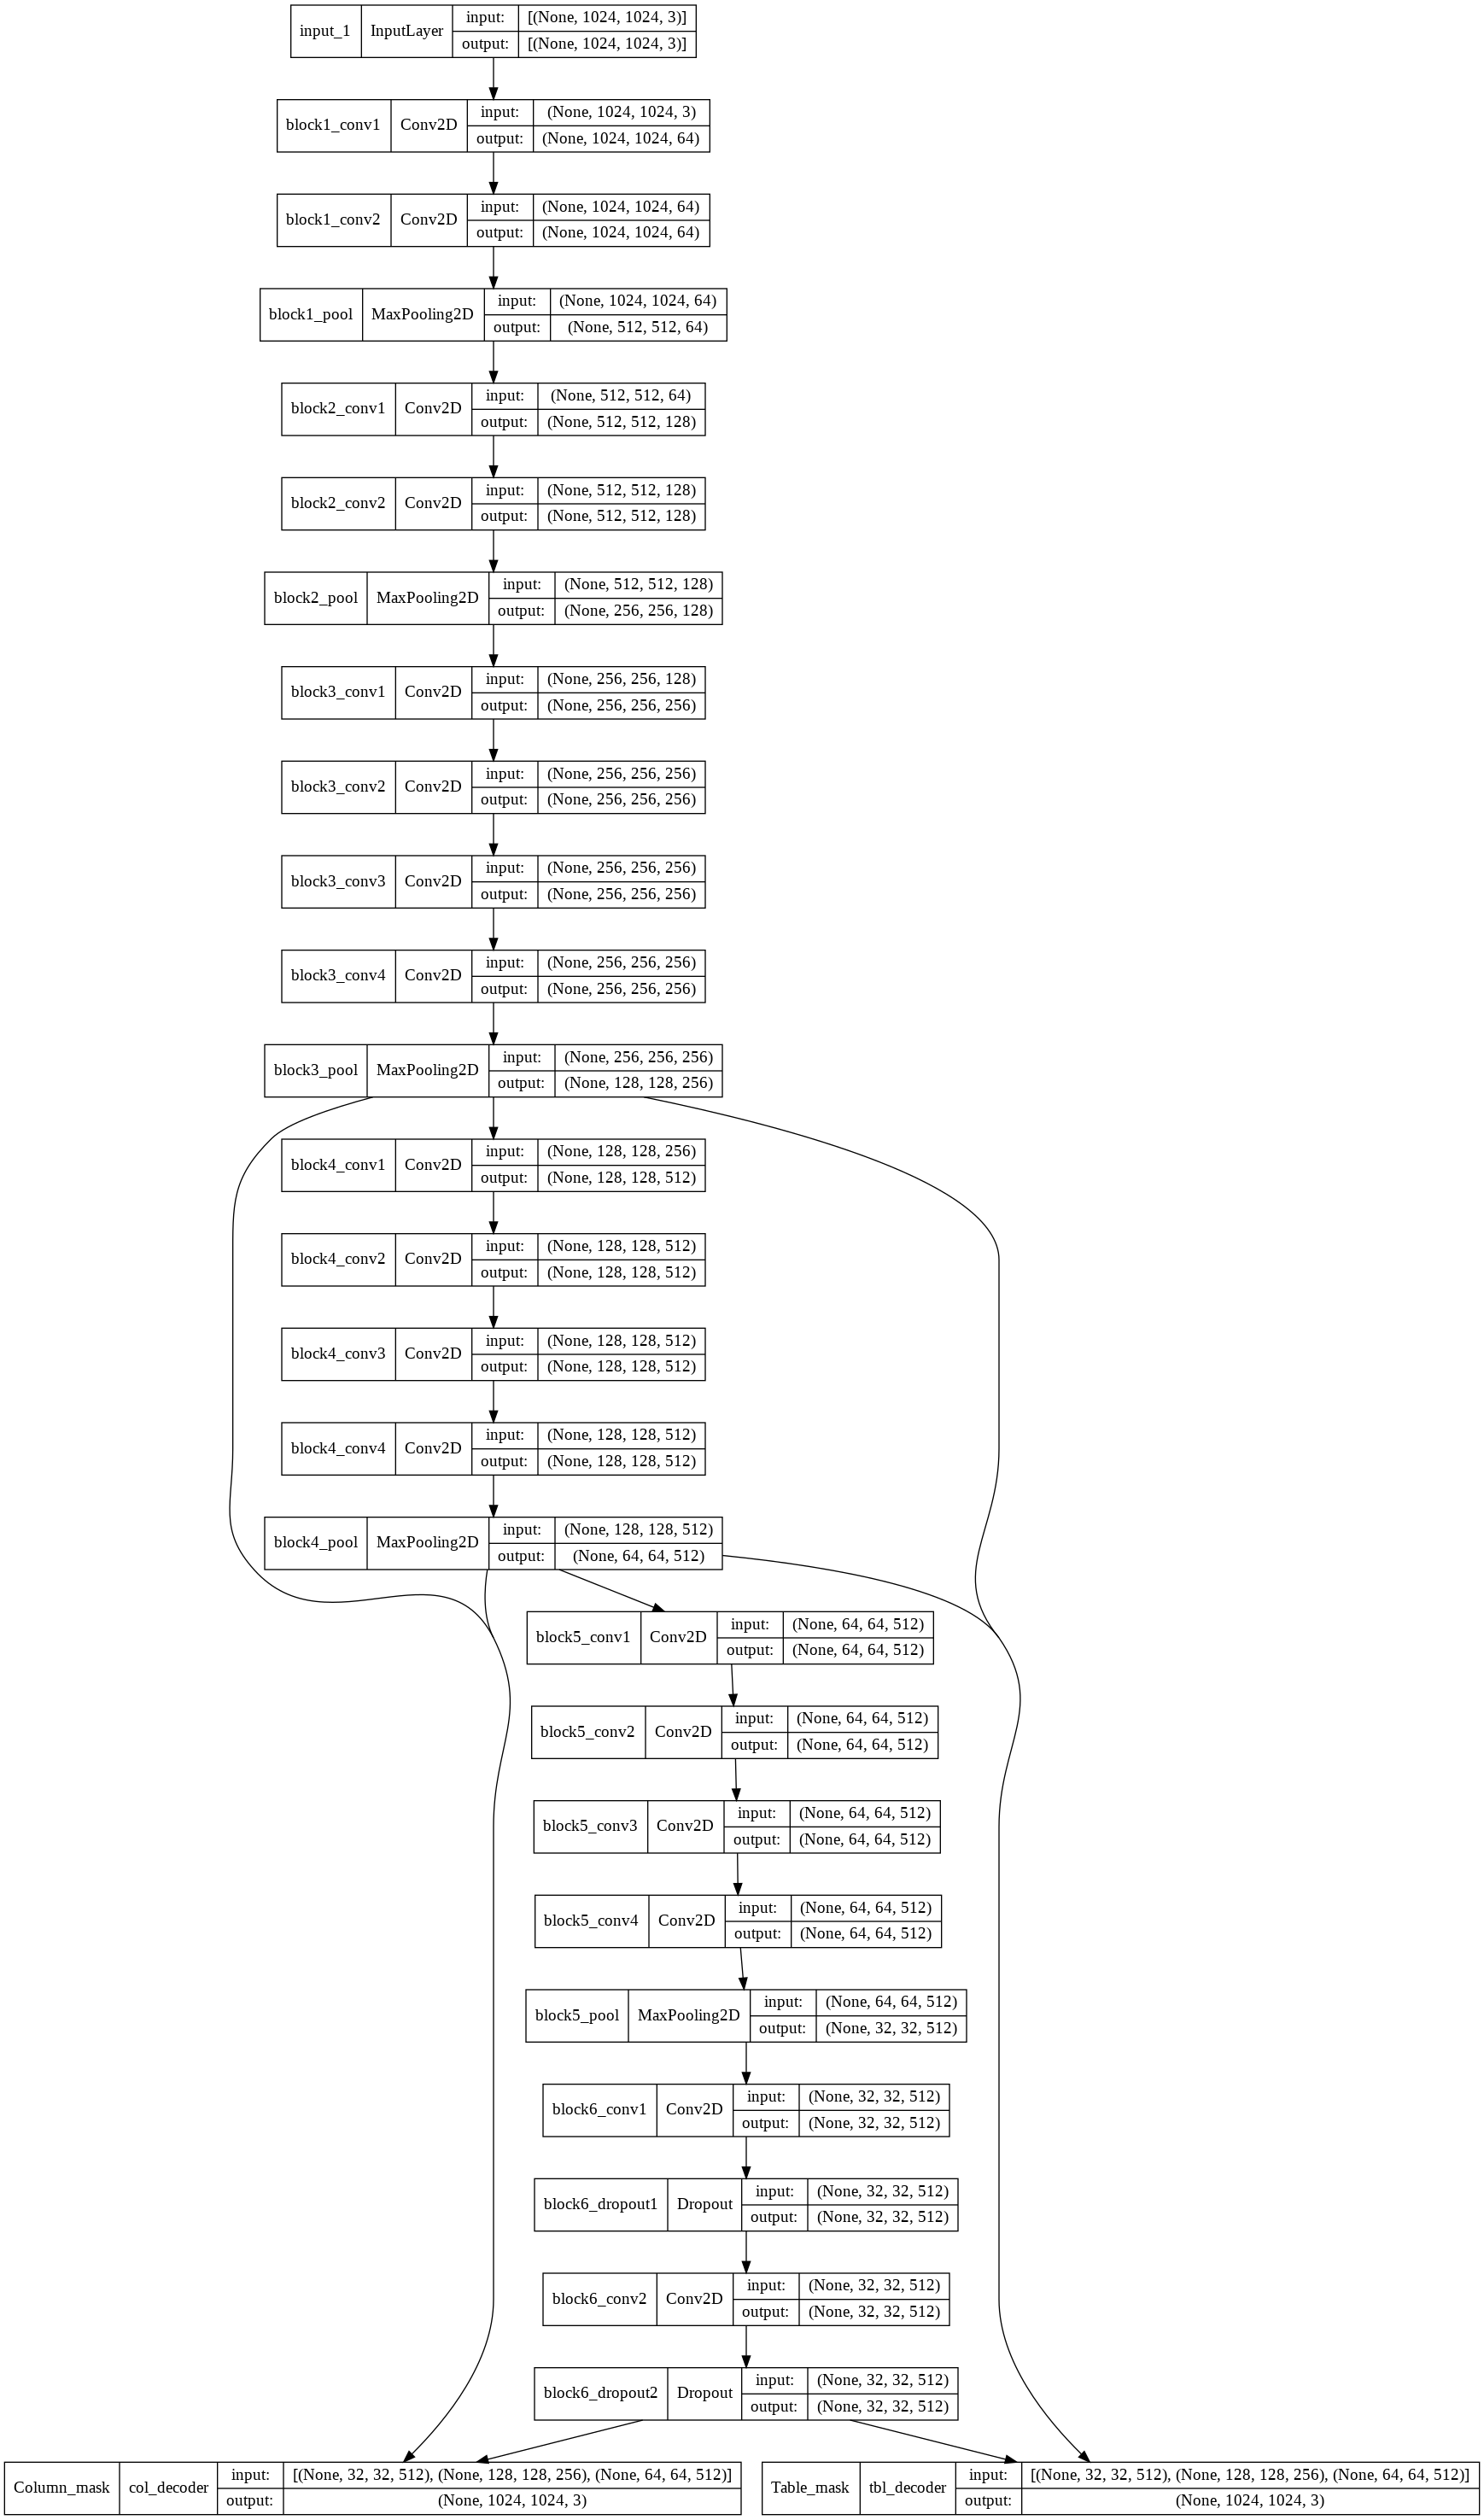

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataloader, test_dataloader, train_steps, val_steps = load_data(BATCH_SIZE = 1, BUFFER_SIZE = 10)

In [ ]:
losses = {"Table_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
          "Column_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)}

loss_weights = {"Table_mask" : 1.0, 
                "Column_mask" : 1.0}

model.compile(optimizer= tf.keras.optimizers.Adam(0.0001, beta_1=0.8), loss = losses, loss_weights=loss_weights, metrics = ['accuracy']) #, F1Sco


In [ ]:
#обучаем модель
filepath="/content/drive/MyDrive/model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,  monitor='val_loss' ,save_best_only=True, mode='auto', verbose = 1 )


hist = model.fit(train_dataloader, epochs =50, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 1.4887 - Table_mask_loss: 0.7721 - Column_mask_loss: 0.7166 - Table_mask_accuracy: 0.6427 - Column_mask_accuracy: 0.6453
Epoch 00001: val_loss improved from inf to 1.06533, saving model to /content/drive/MyDrive/model_save/weights-01-1.0653.hdf5
88/88 [==============================] - 49s 395ms/step - loss: 1.4887 - Table_mask_loss: 0.7721 - Column_mask_loss: 0.7166 - Table_mask_accuracy: 0.6427 - Column_mask_accuracy: 0.6453 - val_loss: 1.0653 - val_Table_mask_loss: 0.5394 - val_Column_mask_loss: 0.5259 - val_Table_mask_accuracy: 0.7403 - val_Column_mask_accuracy: 0.6994
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 1.0128 - Table_mask_loss: 0.5015 - Column_mask_loss: 0.5113 - Table_mask_accuracy: 0.7526 - Column_mask_accuracy: 0.7195
Epoch 00002: val_loss improved from 1.06533 to 0.85110, saving model to /content/drive/MyDrive/model_save/weights-02-0.8511.hdf5
88/88 [===========================

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("/content/drive/MyDrive/model_save/weights-04-0.1819--.hdf5")

In [ ]:
def get_mask(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

In [ ]:
def table_detection(path) :
  """Обнаруживает и возвращает таблицу (таблицы) в изображении"""
  if os.path.isdir("Testing") == False:
    os.mkdir("Testing")
  #чтение, изменение размера и нормализация данных изображения
  image = tf.io.read_file(path)
  image = tf.image.decode_image(image, channels=3, expand_animations = False)
  image = tf.image.resize(image, [1024, 1024])  #Decode a JPEG-encoded image to a uint8 tensor
  image = tf.cast(image, tf.float32) / 255.0 # normalizing image
    
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = get_mask(mask1), get_mask(mask2)

  im1=tf.keras.preprocessing.image.array_to_img(image)
  im1.save('/content/Testing/image.png')
        
  im2=tf.keras.preprocessing.image.array_to_img(table_mask)
  im2.save('/content/Testing/table_mask.png')
        
  im3=tf.keras.preprocessing.image.array_to_img(column_mask)
  im3.save('/content/Testing/column_mask.png')

  img_org = Image.open('/content/Testing/image.png')
  img_org = img_org.resize((1024,1024),Image.ANTIALIAS)

  print("\n")
  print('\033[1m' + "INPUT IMAGE :" + '\033[0m')
  print("\n")

  plt.figure(figsize=(10,40))
  plotting = plt.imshow(img_org,cmap='gray')
  plt.show()


  print("\n")
  print("-"*90)
  print("\n")

  print("\n")
  print('\033[1m' + "OUTPUT IMAGE :" + '\033[0m')
  print("\n")


  table_mask = Image.open('/content/Testing/table_mask.png')
  table_mask = table_mask.resize((1024,1024),Image.ANTIALIAS)
  col_mask = Image.open('/content/Testing/column_mask.png')
  #col_mask = col_mask.resize((1024,1024),Image.ANTIALIAS)

  img_mask = table_mask.convert('L')
  # img_mask = col_mask.convert('L')

  img_org.putalpha(img_mask)

  plt.figure(figsize=(10,40))
  plotting = plt.imshow(img_org,cmap='gray')
  plt.show()


  img_org.save('/content/Testing/output.png')

  return

In [ ]:
def get_text():

  #читаем файл
  file=r'/content/Testing/output.png'
  img = cv2.imread(file,0)


  #пороговое значение изображения для двоичного изображения
  thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
  #инвертирование изображения
  img_bin = 255-img_bin
  cv2.imwrite('/content/Testing/cv_inverted.png',img_bin)

  #Длина (ширина) ядра как 100-я часть общей ширины
  kernel_len = np.array(img).shape[1]//100
  #Определение вертикального ядра для обнаружения всех вертикальных линий изображения
  ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
  # Определение горизонтального ядра для обнаружения всех горизонтальных линий изображения
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
  # Ядро 2х2
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

  #Используется вертикальное ядро для обнаружения и сохранения вертикальных линий в формате jpg
  image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
  vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
  cv2.imwrite("/content/Testing/vertical.jpg",vertical_lines)

  #Используется горизонтальное ядро для обнаружения и сохранения горизонтальных линий в формате jpg
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
  cv2.imwrite("/content/Testing/horizontal.jpg",horizontal_lines)

  # Объедините горизонтальные и вертикальные линии в новом третьем изображении с одинаковым весом.
  img_vh = cv2.addWeighted(vertical_lines, 0.9, horizontal_lines, 0.1, 0.0 )
  #Размывание и пороговое значение изображения
  img_vh = cv2.erode(~img_vh, kernel, iterations=2)
  thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY)
  cv2.imwrite("/content/Testing/img_vh.jpg", img_vh)
  bitxor = cv2.bitwise_xor(img,img_vh)
  bitnot = cv2.bitwise_not(bitxor)

  im1=tf.keras.preprocessing.image.array_to_img(bitnot[:,:,np.newaxis])
  im1.save('/content/Testing/image1.png')


  img_mask = Image.open('/content/Testing/column_mask.png')
  img_mask = img_mask.resize((1024,1024),Image.ANTIALIAS)

  img_mask = img_mask.convert('L')
  im1 = Image.open('/content/Testing/image1.png')
  im1 = im1.resize((1024,1024),Image.ANTIALIAS)

  im1.putalpha(img_mask)
  im1.save('/content/Testing/image1.png')


  print("\n")
  print("-"*90)
  print("\n")
  print('\033[1m' + "RETRIEVED TEXT :" + '\033[0m')
  print("\n")
  
  text_list = pytesseract.image_to_string(Image.open('/content/Testing/image1.png'), lang='eng' )
  text_list = text_list.split('\n')
  while("" in text_list)  :
    text_list.remove("")
  while(" " in text_list)  :
    text_list.remove(" ")
  while("  " in text_list) :
    text_list.remove("  ")

  for i in text_list:
    print(i)

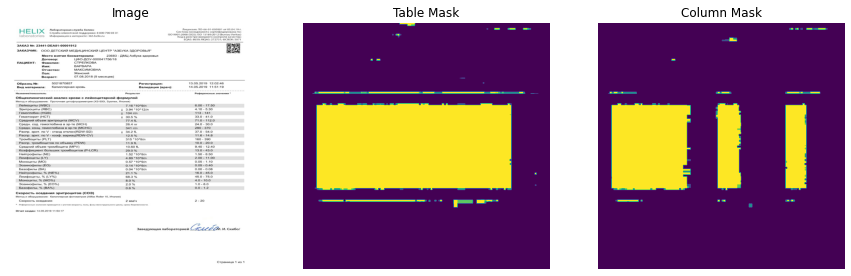

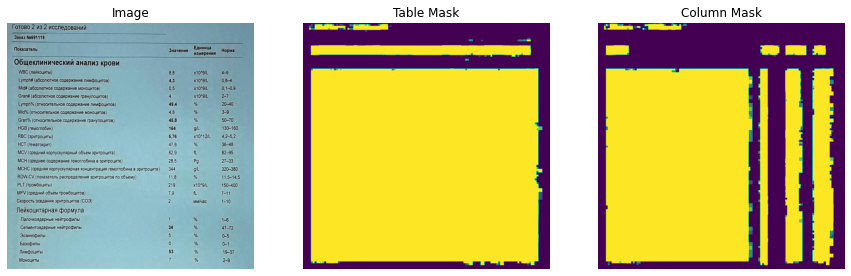

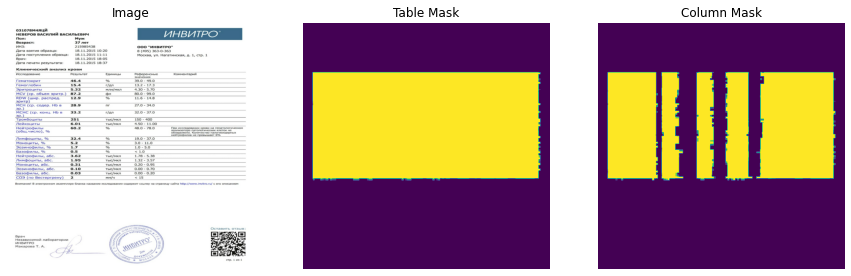

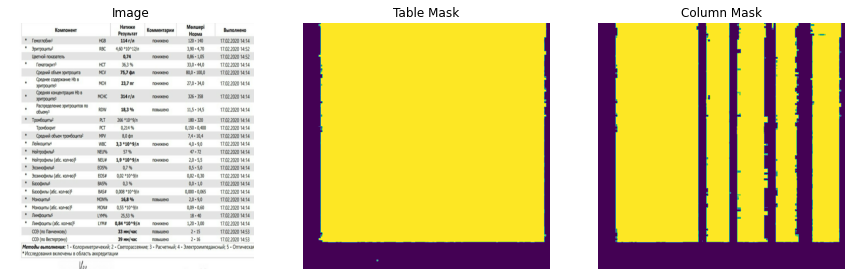

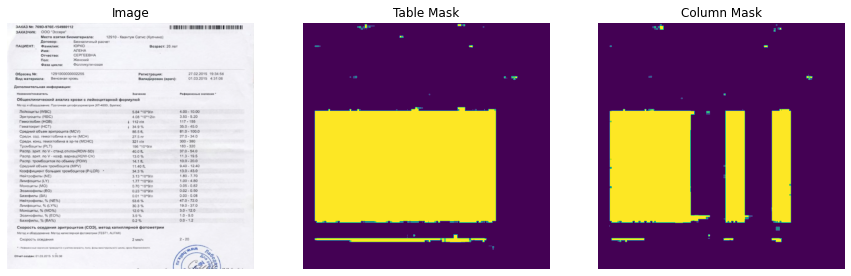

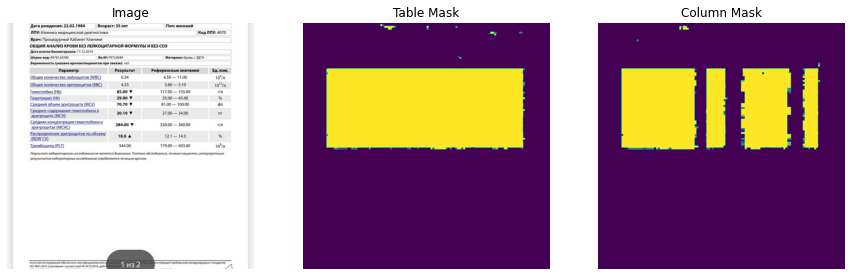

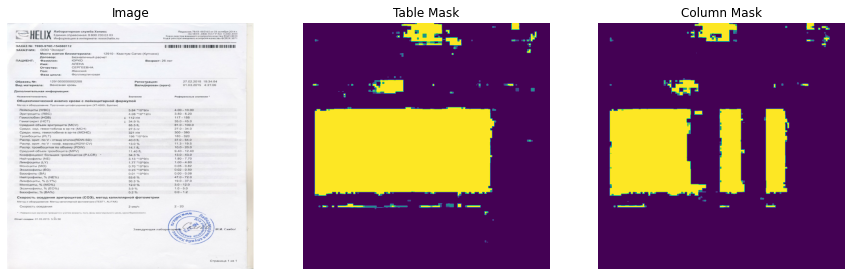

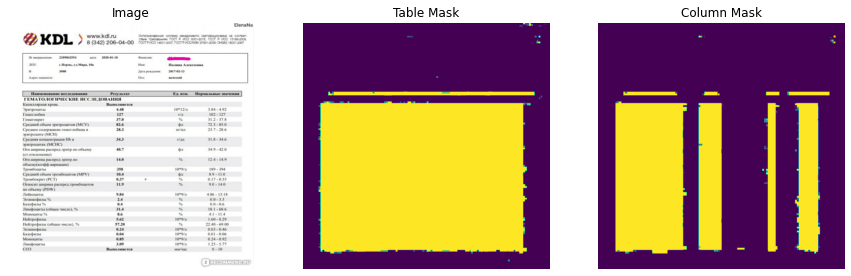

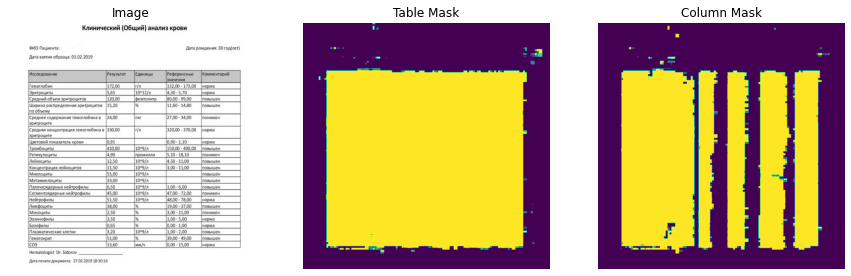

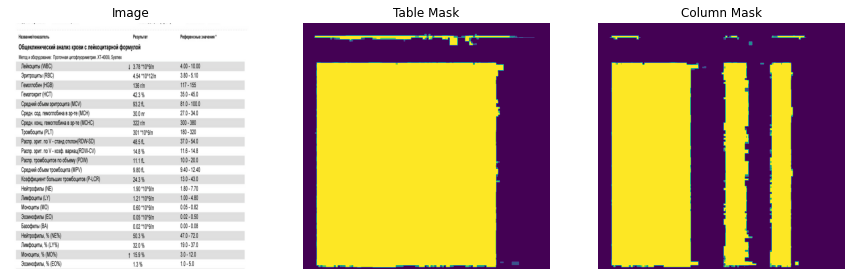

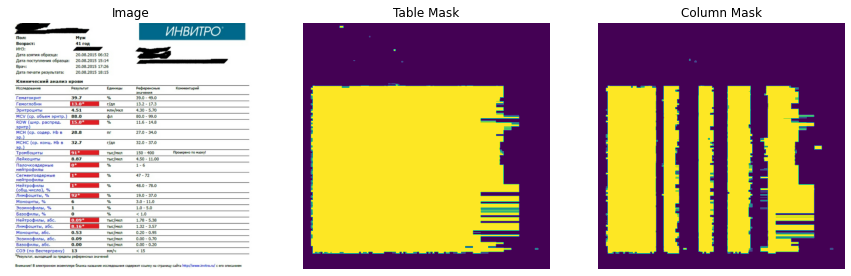

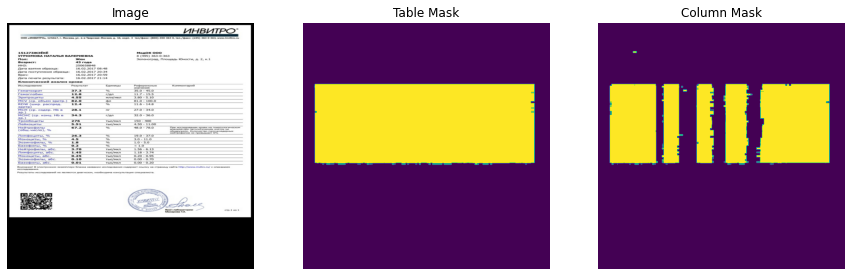

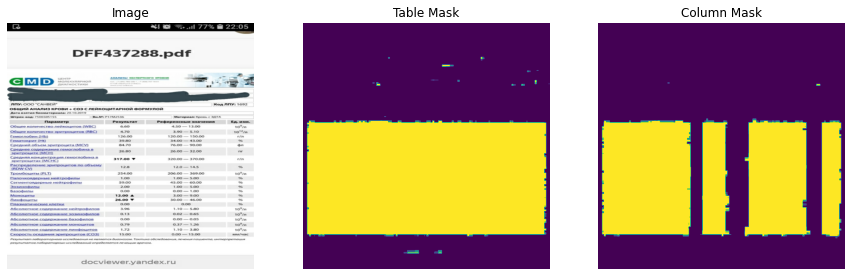

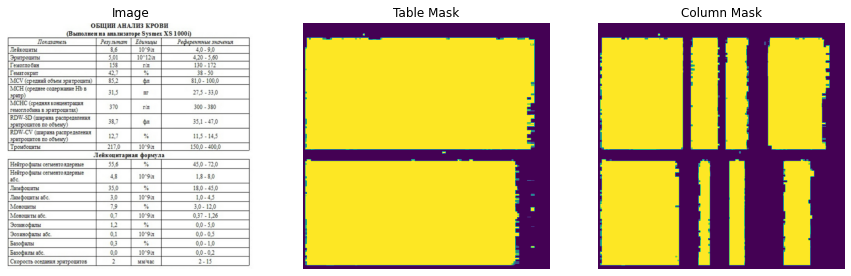

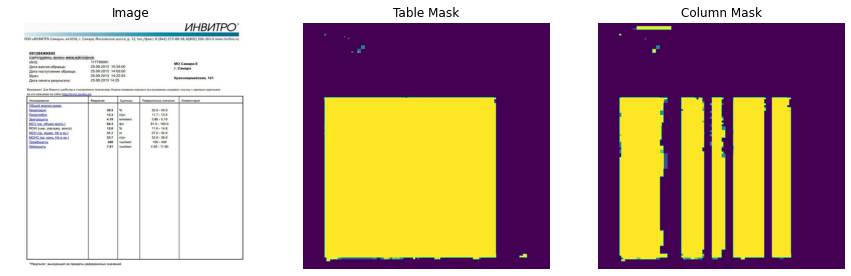

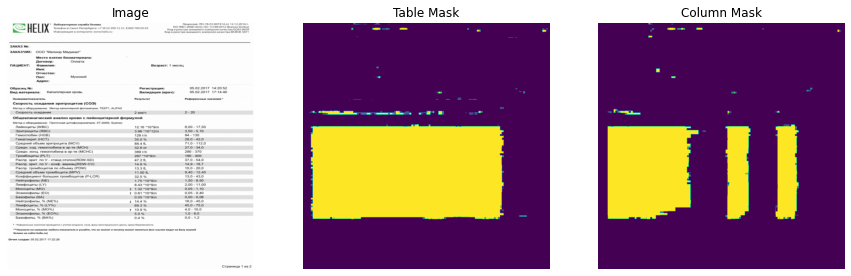

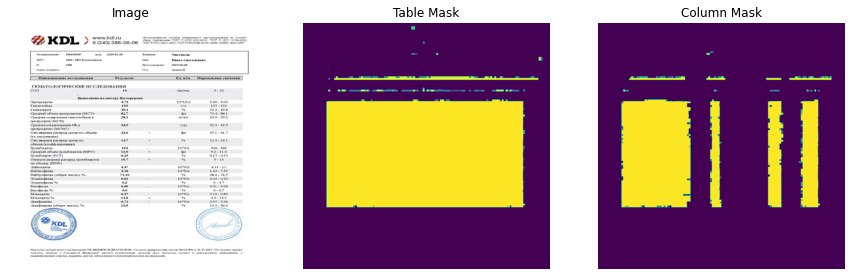

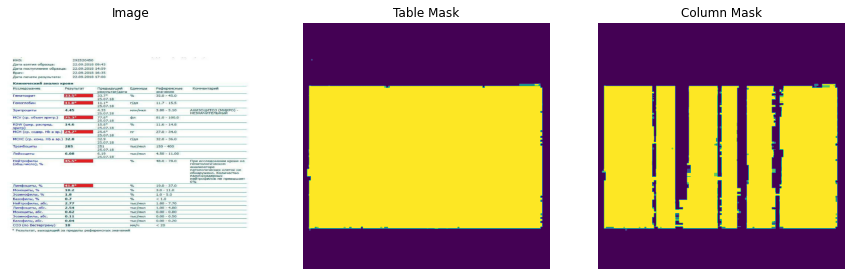

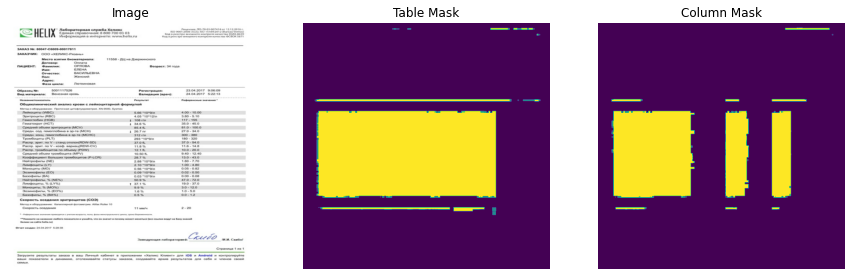

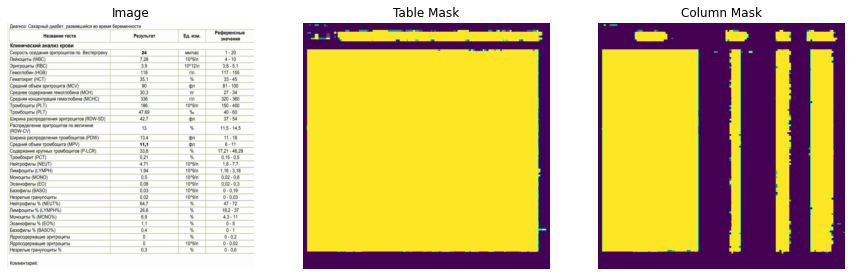

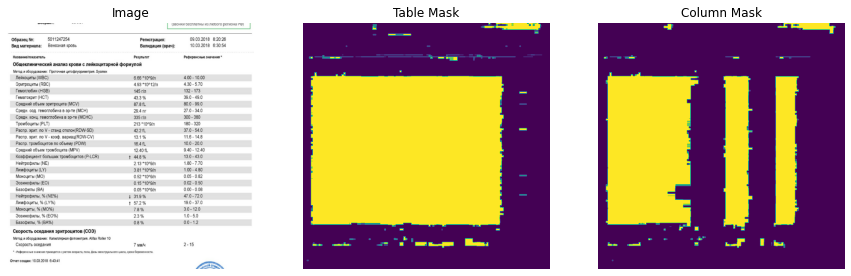

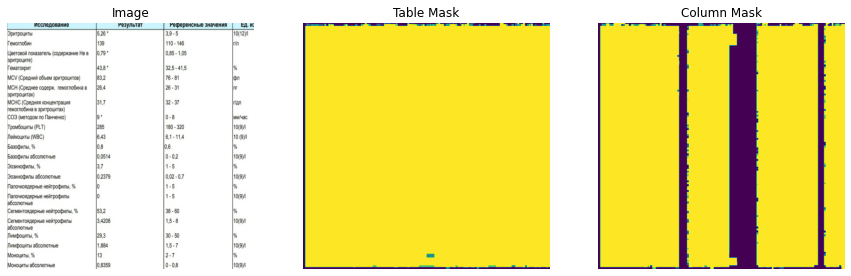

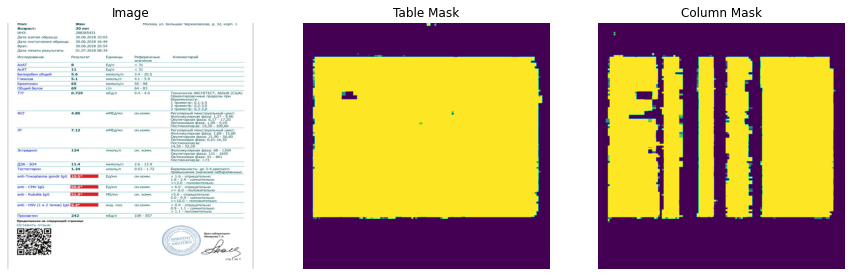

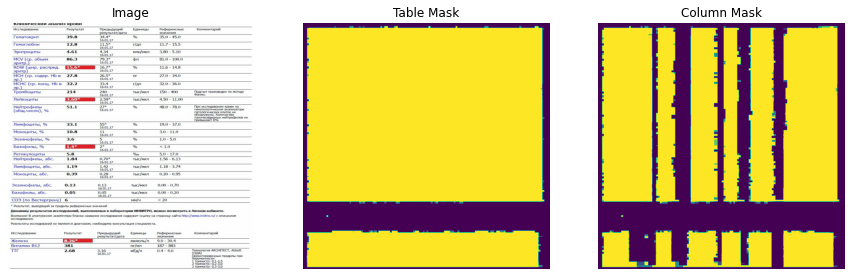

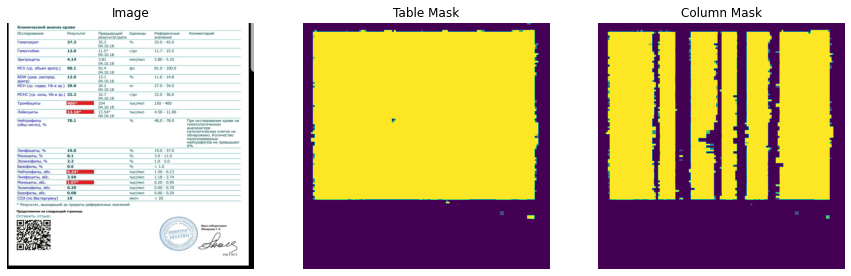

In [ ]:
number = 25
for image, mask  in train_dataloader.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image)
  table_mask, column_mask = get_mask(mask1),get_mask(mask2)
  image = image[0]
  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()



INPUT IMAGE :




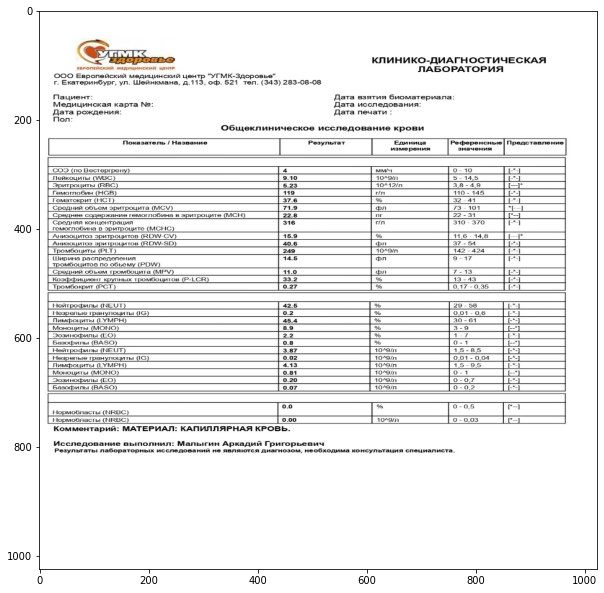



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




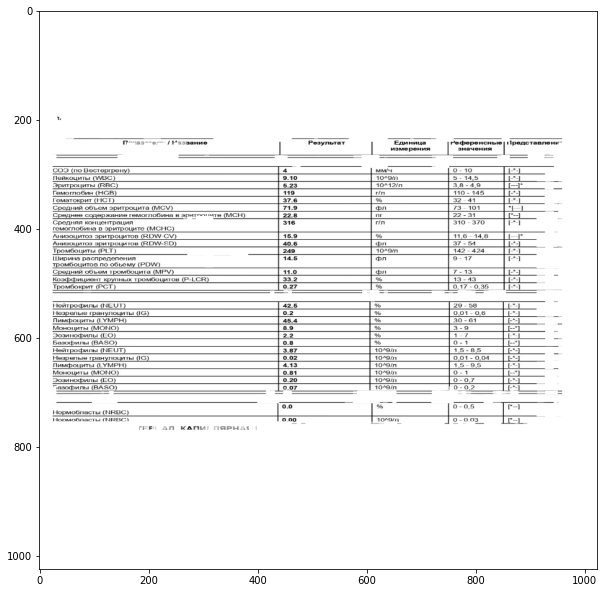



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


we
Texesaven 7H
   
vamepent
Jepapencne
Sea meBecreprpemy z sama 1o=70
Temcourrne: (WBC) #0 io"am s145
Spnrpounres (RBC) 323 TOMA aaa
Temomobme (HCB) 10 tn ho=1a5
Tomaroupur (HCT) are 5 Soot
‘Cpoainn obvom opmrpaunra (CV) ms on 73-108
Spepnes conepaarne remorncOme # aparnomre (CH 228 or = Bea
Cheatin wonenTpaivan 316 vn 510-370
remornoonia © aprmpouTe (MCHC)
‘Aimaouwros opmpounTos (RDW CV) iss x Tea
Annsounios apa ipousios (RDW=SD) s06 on a
‘TpomeouvTe (PLT) 249 10° ap ada
iliMpuna pacnpenenonwA ia8 en a7
spombourrron no obuemy (POW)
‘Coegnna obcer 1pombounia (MEV) ie a os
“oatbpmuor xpyrnex 1pomBounron LOR 332 56 = a3
Tpomoowpur PCT) oar me 1017
Tomrpodane WEUT) Be = = Ss
Heapenuie panynounne GG) a2. & = dors
Tusachouvares (CYMPH) for % 30-01
Mononyrrnt (ONO) ao ie = bs
Soanodunus EO) 22 % = aor
Basocimr GASO) os % ont
Hevirpoduare (NEUT) 3.87 10m = teas
Heapensie rparynou

In [ ]:
table_detection('example.jpg')
get_text()

In [ ]:
def f1_score(true, pred):
  """Возвращает результат F1 """
  re = tf.keras.metrics.Recall()
  re.update_state(true, pred)
  re = re.result().numpy()

  pr = tf.keras.metrics.Precision()
  pr.update_state(true, pred)
  pr = pr.result().numpy()  

  f1 = 2*(re * pr)/(re + pr)
  return f1

In [ ]:
table , column = [] , []
predicted_table_mask , predicted_column_mask = list() , list()
for image, mask  in test_dataloader.take(Test.shape[0]):
  table.append(mask['Table_mask'][0])
  column.append(mask['Column_mask'][0])

  mask1, mask2 = model.predict(image)
  table_mask, column_mask = get_mask(mask1),get_mask(mask2)

  predicted_table_mask.append(table_mask)
  predicted_column_mask.append(column_mask)

In [ ]:
print("F1-Оценка маски таблицы : ",f1_score(table , predicted_table_mask))
print("-"*70)
print("F1-Оценка маски столбца : ",f1_score(column , predicted_column_mask))

F1-Оценка маски таблицы :  0.9758067224602148
----------------------------------------------------------------------
F1-Оценка маски столбца :  0.9264141595970226
